# ASTR3110 Computer Laboratory 1: The Period-Luminosity relation using Cepheid variable stars from Gaia (Week 3, 4, 5).

In this lab, you will use data from the Gaia Data Release 3 (Gaia DR3; also including Gaia Early Data Release 3) to calibrate the Type I Cepheid period-luminosity relation, also known as the "Leavitt's law" honouring Henrietta Swan Leavitt who first discovered the relation using Cepheids in the Large Magellanic Cloud. We discussed the Period-Luminosity relation for Type I Cepheids in the Week 2 lectures.

In the first part of the lab, you will hone your data massaging skills using Pandas to weed out bad data in order to select a high-fidelity sample of Type I Cepheids (also known as Delta Cepheids or Classical Cepheids) ready for calibrating the Leavitt law. You will determine which of the parameters are required for measuring Leavitt's law, and also calculate the required new quantities and associated uncertainties.

In the second part of the lab, you will use your knowledge of fitting data to determine the best-fitting straight-line parameterisation of Leavitt's Law. You will use two methods to do this: standard optimisation and MCMC. You will compare the results from the two methods, and also compare the results of the two different measurements of distance derived from the Gaia parallax measurements.

In the third part of the lab, you will use your calibrated Leavitt Law to determine the distance to the Large Magellanic Cloud.

<font color='red'> **Checkpoints for where you should aim to be up to at the end of each lab are highlighted in red throughout the notebook.**</font>

At the completion of this lab, you will have acquired (or improved) the following skills:
- Data filtering using Pandas.
- Manipulating data to derive required parameters.
- Plotting data and interpreting plots.
- Fitting models to data using standard optimisation and MCMC.

You will be required to submit **two separate files** via iLearn (see the lab submission portal in the Assessments tab) by 11:55pm Monday 1st April 2024. The files are:

1. **Your Colab notebook containing your code.** We will randomly select code cells to inspect and will mark them based on the following criteria, each worth **10 marks**:
    - **Comments: Your code must be commented and your comments should demonstrate that you understand what your code is doing, and why! You can insert comments by either adding explanation text placed in blocks just before code blocks OR as comments within the code blocks themselves. The marking rubric is as follows:**

            8.5-10: Thorough comments that clearly explain what and why, demonstrating excellent understanding of code.
            7.5-8.5: Comments that explain what and mostly why, demonstrate good understanding.
            6.5-7.5: Comments that mostly explain what, not why, mostly demonstrate understanding.
            5.0-6.5: Some comments explaining what or why, some demonstration of understanding.
            < 5.0: Minimal comments.

    - **Formatting of your code. Rubric:**

            8.5-10: Code is clear and easy to understand with sensible variable names.
            7.5-8.5: Mostly clear, understandable with semi-sensible variable names.
            6.5-7.5: Code is understandable OR good variable names.
            5-6.5: Some effort in formatting code OR using sensible variable names.
            < 5.: Spaghetti code, remnants of code bits that failed to run.

2. **A document (preferrably in pdf format) that contains the plots, answers to questions, and explanation requests <font color='blue'>highlighted in blue throughout the notebbook.</font>** We will mark those based on the following criteria, again worth **10 marks** each:
    - **Plots: Your plots should be well presented and explained. Rubric:**

            8.5-10: All requested plots are included and are accompanied by a caption that thoroughly explains them and details what they show and why plotted. Plots have clear symbols, clearly labeled axes, and axis ranges are set so that trends visible.
            7.5-8.5: All requested plots included and accompanied by captions that mostly explain what and why. Plots include good labels, ranges, and symbols.
            6.5-7.5: Most requested plots are included and captions mostly explain what. Good labels, ranges, and symbols.
            5-6.5: Most requested plots included, captions contain some explanation. Adequate labels, ranges, and symbols.
            < 5.0: Many missing plots, minimal effort in explaining or making sure plots/labels are clear.

    - **Comments and answers to any questions posed in the notebooks as well as comments on interpretation/comparison of results. Rubric:**

            8.5-10: Correct, detailed answers and comments for all questions and comparisons/interpretation.
            7.5-8.5: Correct answers and comments for most questions and comparisons/interpretations.
            6.5-7.5: Correct answers and comments for subset of questions and comparisons/interpretations.
            5-6.5: Some effort at answering questions and/or comparing/interpreting results.
            <5: No/minimal effort.

    - **Thorough explanations and justification for filtering of the data. Rubric:**

            8.5-10: Complete, thorough explanation and justification of how and why filtering was performed on the data. Demonstrates thorough understanding.
            7.5-8.5: Complete description of data filtering that mostly includes explanation AND justification.
            6.5-7.5: Filtering mostly explained OR justified.
            5-6.5: Some effort at one of explaining or jusitifying.
            <5: No/minimal effort at explaining or justifying data filtering.


# Part 1: Obtaining the data and applying basic filters

In this part, we will retrieve the Gaia data from the archive, and weed out obviously bad data.
## 1.1 Downloading the data

The data for this practical comes from the [Gaia](https://www.cosmos.esa.int/web/gaia/) mission and must be downloaded from the online Gaia archive at [http://gea.esac.esa.int/archive/](http://gea.esac.esa.int/archive/). The tabular data is retrieved from the database via an astronomy data query language (ADQL) statement:

```
SELECT source_id, dist.r_med_geo, dist.r_lo_geo, dist.r_hi_geo, dist.flag, src.ra, src.dec, src.L, src.B, src.parallax, src.parallax_error, cep.type_best_classification, cep.mode_best_classification, cep.pf, cep.pf_error, cep.int_average_bp, cep.int_average_bp_error, cep.int_average_g, cep.int_average_g_error, cep.int_average_rp, cep.int_average_rp_error, cep.num_clean_epochs_g
FROM external.gaiaedr3_distance as dist
JOIN gaiadr3.vari_cepheid AS cep USING (source_id)
JOIN gaiadr3.gaia_source AS src USING (source_id)
```

This query selects multiple columns from 3 tables in the archive that are merged using a common ```source_id``` column. We will describe what data each of the columns contains later in this notebook.

At the Gaia archive page linked above, go to Search -> Advanced (ADQL) and copy the query into the box. Run the query and when finished save locally using the download icon on the right in the job window. Once you have the file on your local disk, you will need to upload to your google drive in order to allow Colab to access the data. Save the file to the same working directory that your Lab 1 python notebook is stored in. Note that the downloaded file compressed as a 'GZIP' archive.

In the cell below, import your google drive so that Colab can access the data there (see instructions at [link](https://github.com/MQ-ASTR3110/ASTR3110_Tutorial_Notebooks_2024/blob/master/SETUP_COLAB.md)). Change to the directory that the Gaia data are saved under, and unzip the file using the command ```!gunzip filename.gz``` in a cell. Double check to make sure all has gone to plan (e.g., run the !ls command to list the files in your current directory).

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
#This allows the notebook to access the files stored in my google drive

import os
os.chdir('/content/gdrive/MyDrive/Colab Notebook')
#This changes the current working directory to the specified path.




Mounted at /content/gdrive


In [ ]:
pwd

'/content/gdrive/MyDrive/Colab Notebook'

## 1.2 Inspecting the data

The tabular data is in an XML-like format called 'VOTable', where VO stands for 'virtual observatory'. Dedicated software like [TOPCAT](http://www.star.bris.ac.uk/~mbt/topcat/) can be used to view, manipulate and plot the data. However, for our analysis we will convert the table to a [Pandas](https://pandas.pydata.org/) dataframe. As you will recall from the second lectorial, Pandas is a high-performance module for doing data analysis with Python and is used widely outside of astronomy.

In [ ]:
# Start by importing necessary Python modules
from astropy.io.votable import parse
import pandas as pd
import numpy as np

In [ ]:
# Define a function to read a VOTable and return a DataFrame
def votable_to_pandas(voTabFileName, indx=0):
    """
    Reads a VOTable file and returns a Pandas dataframe.
    Reads only one sub-table, specified by the indx argument.
    """

    # Parse the VOTable into a table tree & convert 1st sub-table to an AstroPy table
    voTabTree = parse(voTabFileName)
    apTab = voTabTree.get_table_by_index(indx).to_table(use_names_over_ids=True)

    return apTab.to_pandas()

Now we run our conversion function on the VOTable to read the table into memory. The converter may issue a few warnings, but these can be safely ignored. In the cell below, use the function defined above to read your VOTable into a Pandas DataFrame.

In [ ]:
def votable_to_pandas(GaiaDataLab1, indx=0):
    """
    Reads a VOTable file and returns a Pandas dataframe.
    Reads only one sub-table, specified by the indx argument.
    """

    # Parse the VOTable into a table tree & convert 1st sub-table to an AstroPy table
    voTabTree = parse(GaiaDataLab1)
    #This line uses a parse function to read the VOTable file and create a structure that can be navigated, referred to as voTabTree.
    apTab = voTabTree.get_table_by_index(indx).to_table(use_names_over_ids=True)
    #This piece of code helps us in retrieving a sub-table at the position indicated by indx.

    return apTab.to_pandas()
    # Finally, the code here converts the AstroPy table object into a Pandas DataFrame.


We can inspect the format of the table using the ```head()``` method of the dataframe ('methods' are functions that live inside python 'objects', like tables, and operate only on the parent object). In the cell below, print the first 10 rows.

In [ ]:
GaiaDataLab1df = votable_to_pandas('GaiaDataLab1')
GaiaDataLab1df.head(10)
# Executing this code displays the first 10 rows of the DataFrame.
# GaiaDataLab1df is the name of our DataFrame.

,source_id,r_med_geo,r_lo_geo,r_hi_geo,flag,ra,dec,L,B,parallax,...,mode_best_classification,pf,pf_error,int_average_bp,int_average_bp_error,int_average_g,int_average_g_error,int_average_rp,int_average_rp_error,num_clean_epochs_g
0,4658032774371311104,17579.615234,13895.960938,24944.583984,10033,83.489627,-69.566218,280.070720,-32.028795,-0.049756,...,FUNDAMENTAL,6.531933,0.000265,16.410542,0.011349,15.903271,0.001245,15.190373,0.001304,41
1,4658035626229427456,7990.631348,6084.453613,10997.094727,10023,83.509792,-69.412324,279.889758,-32.042957,0.003185,...,FIRST_OVERTONE,NaN,NaN,16.908739,0.013691,16.859545,0.001584,16.021412,0.009499,36
2,4658036274856153856,14324.096680,11278.498047,19461.636719,10023,83.197495,-69.424988,279.922599,-32.149909,-0.073039,...,FIRST_OVERTONE,NaN,NaN,16.288013,0.003790,15.992511,0.001775,15.424621,0.016404,35
3,4658036828819820800,23835.755859,18131.689453,30618.009766,10122,83.193732,-69.373128,279.862181,-32.158564,-0.056151,...,FIRST_OVERTONE,NaN,NaN,15.632494,0.002053,15.356653,0.001255,14.914973,0.011910,38
4,4658039710832195200,7754.655273,6408.205078,9781.739258,10022,83.020517,-69.349151,279.844433,-32.222415,0.086226,...,FUNDAMENTAL,2.911573,0.000092,16.163883,0.006728,15.895083,0.005899,15.423490,0.006654,36
5,4658040745829467392,17115.507812,13333.597656,21751.054688,10033,82.897060,-69.318524,279.816066,-32.269962,-0.006775,...,FUNDAMENTAL,7.809231,0.000228,15.253837,0.003858,14.851229,0.001952,14.282682,0.001260,37
6,4658041222673354112,7849.848633,5956.375977,13040.502930,10022,82.853023,-69.288108,279.783161,-32.289798,0.011581,...,FIRST_OVERTONE,NaN,NaN,17.627754,0.015739,17.392542,0.003418,16.950048,0.005936,35
7,4658041707905510912,10721.492188,8229.466797,13522.274414,10033,82.587990,-69.573595,280.133663,-32.339068,0.031439,...,FUNDAMENTAL,4.166964,0.000201,15.985552,0.007386,15.619689,0.005828,15.100493,0.006497,33
8,4658042287684443648,17435.130859,13831.750000,22782.642578,10023,82.612506,-69.520534,280.070050,-32.338729,0.010302,...,FUNDAMENTAL,10.991700,0.000687,14.445977,0.003147,14.110184,0.001430,13.595924,0.001517,34
9,4658044246159140608,16810.255859,12304.652344,21868.599609,10022,82.702027,-69.454152,279.986772,-32.317784,-0.012648,...,FIRST_OVERTONE,NaN,NaN,15.822980,0.001902,15.545600,0.002139,15.102939,0.002236,36


Note that the leftmost column above displays the row-index of the table. This can be an integer (as above) or a text field. We can see that there are a large number of columns, so the ```head()``` method does not display them all. We can print all the column names like this "gaiaDF.columns". In the cell below, write a for loop that loops through the columns and prints the column number and name.

In [ ]:
for col in GaiaDataLab1df.columns:
  # Access the column using the column name
  print(col)
  #Helps in displaying every column name.

source_id
r_med_geo
r_lo_geo
r_hi_geo
flag
ra
dec
L
B
parallax
parallax_error
type_best_classification
mode_best_classification
pf
pf_error
int_average_bp
int_average_bp_error
int_average_g
int_average_g_error
int_average_rp
int_average_rp_error
num_clean_epochs_g


The meanings of the column names can be found in the [GAIA data model documentation](http://gea.esac.esa.int/archive/documentation/GDR3/Gaia_archive/chap_datamodel/) or viewed as hover help text on the sidebar of the GAIA query page as shown in the image below (image may only render on the github version, sorry!):

![Screenshot 2024-03-05 at 11.57.11 am.png](attachment:18fecd72-9f2f-49d3-9ae2-63409ccfbc78.png)

An important part of both data science and astro research is *understanding* the data you are using. <font color='green'> **(1a)** Using the information at the Gaia webpage, make a new markdown cell where you list each column in the DataFrame, along with a short description of the data contained in the column of interest (be sure to note units in your description!).</font>

In [ ]:
# 1. source_id: A unique single numerical identifier of the source obtained from gaia_source.
# 2. r_med_geo: The median geometric estimate of the distance to the source, in parsecs.
# 3. r_lo_geo : The lower bound of the geometric estimate of the distance, in parsecs.
# 4. r_hi_geo: The upper bound of the geometric estimate of the distance, in parsecs.
# 5. flag: A quality flag for the distance estimate.
# 6. ra: Right ascension of the source in degrees, which is one of the two coordinates used to pinpoint the position of a celestial object in the sky as seen from Earth.
# 7. dec: Declination of the source in degrees, which is the other coordinate used alongside right ascension.
# 8. L: Galactic longitude, a coordinate in the galactic coordinate system, in degrees.
# 9. B: Galactic latitude, another coordinate in the galactic coordinate system, in degrees.
# 10. parallax: The parallax of the source, which is the apparent shift in position of the source due to the orbit of the Earth around the Sun, measured in mili-arcseconds.
# 11. mode_best_classification: Best mode classification estimate out of ‘FUNDAMENTAL’, ‘FIRST_OVERTONE’, ‘SECOND_OVERTONE’, ‘MULTI’,‘UNDEFINED’, ‘NOT_APPLICABLE’.
# 12. pf: Period corresponding to the fundamental pulsation mode in the G band time series, in Days (d).
# 13. pf_error: The error associated with the 'pf' measurement.
# 14. int_average_bp: This column represents the intensity-averaged magnitude of the source in the blue photometer (BP) band.
# 15. int_average_bp_error: The error associated with the intensity-averaged magnitude in the BP band.
# 16. int_average_g: This column represents the intensity-averaged magnitude in the G band, which is a broad optical band in which Gaia measures the brightness of stars.
# 17. int_average_g_error: The error associated with the intensity-averaged magnitude in the G band.
# 18. int_average_rp: The intensity-averaged magnitude in the red photometer (RP) band.
# 19. int_average_rp_error: The error associated with the intensity-averaged magnitude in the RP band.
# 20. num_clean_epochs_g : Number of G FoV epochs used in the fitting algorithm. This parameter is filled with the number of epochs that remain in the G-band light curve after the SOS Cep & RRLyrae outlier removal process.
# 21. parallax_error : Error in parallax calculated through error propagation, measured in mili-arcseconds.
# 22. type_best_classification : Best type classification estimate out of: ‘DCEP’, ‘T2CEP’, ‘ACEP’. Classification of a Cepheid into ‘DCEP’, ‘T2CEP’ or ‘ACEP’ using the period-luminosity relations, which are different for the three different types of Cepheids.

## 1.3 Preliminary Filtering of the Data

Now that we know what the data are, we can remove those rows with missing/Null/NaN/Inf values. In the code cell below, use your knowledge of Pandas functions to list the number of null values for each column.

In [ ]:
null_counts = GaiaDataLab1df.isnull().sum()
# Checks each element in the DataFrame to determine if it is a null value. This method sums up all the True values returned by isnull() for each column.
# In this context, True has a numerical value of 1, and False has a value of 0, so summing them gives the total count of missing values in each column.
# The result of this operation, which is the count of null values for each column, is assigned to the variable null_counts.
print(null_counts)

source_id                      0
r_med_geo                      0
r_lo_geo                       0
r_hi_geo                       0
flag                           0
ra                             0
dec                            0
L                              0
B                              0
parallax                       0
parallax_error                 0
type_best_classification       0
mode_best_classification       0
pf                          5446
pf_error                    5446
int_average_bp               106
int_average_bp_error         106
int_average_g                  0
int_average_g_error            0
int_average_rp               105
int_average_rp_error         105
num_clean_epochs_g             0
dtype: int64


After inspecting the number of null values, you will need to produce a mask that selects only the offending rows and removes them. Be sure to check that your code is doing what you think it is (e.g., inspect the length of newly produced data frames and that the final data frame no longer contains nulls).

In [ ]:
mask1 = GaiaDataLab1df["pf"].isnull()

mask2 = GaiaDataLab1df["pf_error"].isnull()

mask3 = GaiaDataLab1df["int_average_bp"].isnull()

mask4 = GaiaDataLab1df["int_average_bp_error"].isnull()

mask5 = GaiaDataLab1df["int_average_rp"].isnull()

mask6 = GaiaDataLab1df["int_average_rp_error"].isnull()

# Creating a series of boolean masks to filter out rows in the GaiaDataLab1df DataFrame that contain null values in certain columns.

mask=(mask1 | mask3 | mask5)

# This is a combination of mask1, mask3, and mask5 using the bitwise OR operator (|).
# If any of the conditions in mask1, mask3, or mask5 is True (i.e., if any of the specified columns has a null value), the corresponding entry in mask will be True.



In [ ]:
cleanDF=GaiaDataLab1df[~mask]

# This creates a new DataFrame, cleanDF, containing only the rows from GaiaDataLab1df where the mask is False.
# The ~ operator inverts the mask, so instead of selecting rows with nulls, it selects rows without nulls.

null_counts = cleanDF.isnull().sum() #This recalculates the number of null values in each column of the cleanDF DataFrame to verify that rows with null values have been removed.
print(null_counts)

print(cleanDF.shape)
print(GaiaDataLab1df.shape)
# For comparison, we print the shape of the original GaiaDataLab1df DataFrame.
# We can compare the number of rows before and after the filtering to see how many rows have been dropped.


source_id                   0
r_med_geo                   0
r_lo_geo                    0
r_hi_geo                    0
flag                        0
ra                          0
dec                         0
L                           0
B                           0
parallax                    0
parallax_error              0
type_best_classification    0
mode_best_classification    0
pf                          0
pf_error                    0
int_average_bp              0
int_average_bp_error        0
int_average_g               0
int_average_g_error         0
int_average_rp              0
int_average_rp_error        0
num_clean_epochs_g          0
dtype: int64
(9473, 22)
(14992, 22)


## 1.4 Selection of Classical Cepheids

During the query of the Gaia archive, we also cross matched to the gaiadr3.vari_cepheid catalogue. This catalogue contains information on Cepheid varible stars including classification of the pulsation mode and the Cepheid type. Use Pandas "groupby" functionality to look at the different classifications.

In [ ]:
cepheid_types = cleanDF.groupby('type_best_classification').describe()

# groups the cleanDF DataFrame by the 'type_best_classification' column.
# The .describe() function generates descriptive statistics that summarize the central tendency, dispersion, and shape of each group's distribution but we will not be using this.
# 'cepheid_types' is the new name being given to the DataFrame here.

print(cepheid_types)

                         source_id                                            \
                             count          mean           std           min   
type_best_classification                                                       
ACEP                         189.0  4.662452e+18  9.019842e+17  4.234546e+17   
DCEP                        7738.0  4.208106e+18  1.389887e+18  6.125971e+16   
T2CEP                       1546.0  4.486229e+18  1.272985e+18  1.542556e+17   

                                                                    \
                                   25%           50%           75%   
type_best_classification                                             
ACEP                      4.655479e+18  4.685783e+18  4.688996e+18   
DCEP                      4.651510e+18  4.661496e+18  4.688426e+18   
T2CEP                     4.059592e+18  4.328983e+18  5.431459e+18   

                                       r_med_geo                ...  \
                           

<font color='green'> **(1b)** Filter your catalogue so that it contains only Classical Cepheids (DCEP) observed during their Fundamental pulsation mode. These are the Cepheids that we will use for the remainder of the prac. </font>

In [ ]:
dcep_mask = cleanDF['type_best_classification'] == 'DCEP'

# A mask for selecting only Classical Cepheids (DCEP)

fundamental_mask = cleanDF['mode_best_classification'] == 'FUNDAMENTAL'

# A mask for selecting only those observed in their Fundamental pulsation mode
# Apply both masks to filter the DataFrame
cepheid_types2 = cleanDF[dcep_mask & fundamental_mask]

# Now, 'cepheid_types2' is our new filtered DataFrame that contains only classical cepheids observed during their fundamental pulsation mode

print(cepheid_types2)


                 source_id     r_med_geo      r_lo_geo      r_hi_geo   flag  \
0      4658032774371311104  17579.615234  13895.960938  24944.583984  10033   
4      4658039710832195200   7754.655273   6408.205078   9781.739258  10022   
5      4658040745829467392  17115.507812  13333.597656  21751.054688  10033   
7      4658041707905510912  10721.492188   8229.466797  13522.274414  10033   
8      4658042287684443648  17435.130859  13831.750000  22782.642578  10023   
...                    ...           ...           ...           ...    ...   
14982  2018778051011957376   7141.135742   6071.462891   9097.218750  10033   
14984  2018900951456670208   9930.901367   8133.830078  12532.222656  10033   
14985  6666081030586994304   8112.983398   6879.636719   9871.663086  10033   
14986  4070454413368471040   6607.472168   5367.879395   8654.468750  10033   
14990  3329849043206545920   2463.379395   2347.978760   2566.502441  10033   

               ra        dec           L          B

## 1.5 Comparing different distance measures

In this Lab, we will need to use the Gaia parallax measurements to determine the distance to our Cepheids in order to determine their absolute magnitudes. There are two main ways to do this. The first is the naive way that we learned in the lectures, i.e., a simple inversion of the parallax in arcseconds gives the distance in parsecs. As we saw in the lectures, this can lead to biased measures of distance when the uncertainty on the parallax is close to its measured value.

In the query at the beginning, we linked to the external.gaiaedr3_distance catalogue. From this catalogue we have r_med_geo, r_lo_geo, and r_hi_geo measures of the distance and lower and upper confidence estimates to a star (they are the 16th and 84th percentile ranges that represent the 1-\$\sigma$ uncertainty). These values are derived by using Bayesian techniques that use the combination of the parallax measurement and our prior knowledge of how stars are distributed in the Galaxy (see [Bailer-Jones et. al 2018](https://iopscience.iop.org/article/10.3847/1538-3881/aacb21)).

In a new code cell, use the inverse parallax method to determine the distance to each star. Use standard error propagation to determine the error on the distance. Add both of these columns to your dataframe.

Hint: disregarding correlations between variables, for a function $f(x,y,z...)$ standard error propagation can be determined as:

$$ \sigma_f^2 = \left({\delta f \over \delta x}\right)^2 \sigma_x^2 + \left({\delta f \over \delta y}\right)^2 \sigma_y^2 + \left({\delta f \over \delta z}\right)^2 \sigma_z^2 ...$$
Where $\sigma_x$ gives the error on parameter $x$, $\sigma_y$ the uncertainty on $y$ etc.

In [ ]:
# Invert the parallax to get the distance in parsecs.
cepheid_types2['distance'] = 1 / (cepheid_types2['parallax'] /1000)

# Here, we are using the formula D = 1/p in order to make our Naive Distance estimates and 'cepheid_types2['distance']' represents the new column 'distance' which will be added
# to our DataFrame. We divide our Parallax by thousand since it is in mili-arcseconds and we have to convert it into arcseconds.

# Calculating the error on the distance using error propagation.
cepheid_types2['distance_error'] = ((cepheid_types2['parallax_error']/1000) / (cepheid_types2['parallax']/1000)**2)

# Here, we are calculating the error in our Naive Distance Estimates using the error propagation formula given above and 'cepheid_types2['distance_error']' represents the new column
# 'distance_error' being added to our DataFrame.

print(cepheid_types2)

                 source_id     r_med_geo      r_lo_geo      r_hi_geo   flag  \
0      4658032774371311104  17579.615234  13895.960938  24944.583984  10033   
4      4658039710832195200   7754.655273   6408.205078   9781.739258  10022   
5      4658040745829467392  17115.507812  13333.597656  21751.054688  10033   
7      4658041707905510912  10721.492188   8229.466797  13522.274414  10033   
8      4658042287684443648  17435.130859  13831.750000  22782.642578  10023   
...                    ...           ...           ...           ...    ...   
14982  2018778051011957376   7141.135742   6071.462891   9097.218750  10033   
14984  2018900951456670208   9930.901367   8133.830078  12532.222656  10033   
14985  6666081030586994304   8112.983398   6879.636719   9871.663086  10033   
14986  4070454413368471040   6607.472168   5367.879395   8654.468750  10033   
14990  3329849043206545920   2463.379395   2347.978760   2566.502441  10033   

               ra        dec           L          B

<ipython-input-14-c31223036c55>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cepheid_types2['distance'] = 1 / (cepheid_types2['parallax'] /1000)
<ipython-input-14-c31223036c55>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cepheid_types2['distance_error'] = ((cepheid_types2['parallax_error']/1000) / (cepheid_types2['parallax']/1000)**2)


In [ ]:
# We can notice that the error in distance is almost the same as the distance itself. This is because the error in parallax is along the same lines as that of the Parallax value
# itself. This happens because the objects that we are trying to observe are so far that our accuracy in the parallax measurements decreases considerably given that the Variable
# catalogue of GaiaDR3 has the parallax measurements in mili-arcseconds. It's due to this reason that the parallax error is almost the same as the parallax itself because the
# parallax angle that we are trying to observe is very very small. This corresponds to giving us distance errors that are almost the same as the distance itself.

<font color='green'>**(1c)** Using a plot, compare the naive estimate of distance to the r_med_geo values. Explain what you see.</font>

<ipython-input-16-672d6aeb6482>:17: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0,100000)
<ipython-input-16-672d6aeb6482>:18: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,100000)


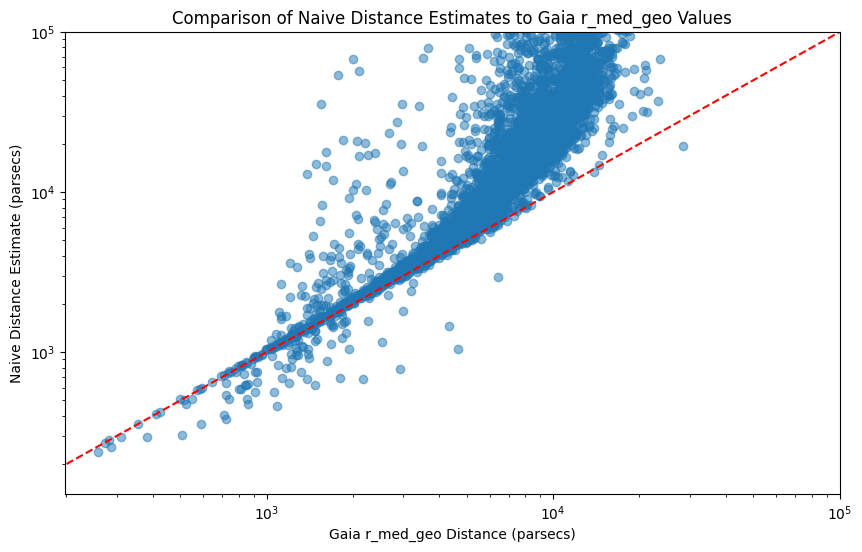

In [ ]:
import matplotlib.pyplot as plt

# Create a scatter plot
plt.figure(figsize=(10, 6)) # This creates a new figure with a width of 10 inches and a height of 6 inches.
plt.scatter(cepheid_types2['r_med_geo'], cepheid_types2['distance'], alpha=0.5) # This line creates a scatter plot using our 2 sets of distance measurements.

# Add titles and labels
plt.title('Comparison of Naive Distance Estimates to Gaia r_med_geo Values')
plt.xlabel('Gaia r_med_geo Distance (parsecs)')
plt.ylabel('Naive Distance Estimate (parsecs)')

# Set the axes to logarithmic scale
plt.xscale('log')
plt.yscale('log')

# Setting a limit to the values to be displayed on both the axes.
plt.xlim(0,100000)
plt.ylim(0,100000)

# The reason why we're setting a limit on the value to be displayed on both the axes is because of the results we obtain through our Naive Distance Measurements. This is because
# these measurements are made using the formula D = 1/p where 'p' is the parallax and since we are trying to look at stars that are extremely far, our precision in the
# measurement of the parallax angle decreases a lot. This is also shown in our catalogue for GaiaDR3 where it can be seen that the 'parallax_error' is almost the same as
# the 'parallax' measurement itself. Due to this lack of precise measurement, we get Naive Distance measurements as far as 10^6 and 10^7 parsecs but the value of our
# Bailer-Jones distance estimates go as high as about 58,000 parsecs which is between 10^4 and 10^5. This is why a x-limit and y-limit of 10^5 is made and this also conceptually
# shows how the Bailer-Jones distance estimate or r_med_geo is a more accurate measurement of the distance.

# Show a line representing perfect agreement
plt.plot((0,100000), (0,100000), color='red', linestyle='--')

# Display the plot
plt.show()

Since we will be comparing the results of our Leavitt Law using both the naive and Bailer-Jones distance estimates, you will need to remove rows with non-sensical inverse parallax distance estimates (e.g., negative parallax measurements).

In [ ]:
# We filter out rows where the parallax is less than or equal to zero
cepheid_types3 = cepheid_types2[cepheid_types2['parallax'] > 0]

# With this code, our new DataFrame, 'cepheid_types3' now only has parallax values that are greater than 0.

print(cepheid_types3)


                 source_id     r_med_geo      r_lo_geo      r_hi_geo   flag  \
4      4658039710832195200   7754.655273   6408.205078   9781.739258  10022   
7      4658041707905510912  10721.492188   8229.466797  13522.274414  10033   
8      4658042287684443648  17435.130859  13831.750000  22782.642578  10023   
12     4658044869001119104  19229.738281  16250.982422  22916.783203  10033   
13     4658046002872198528  13338.875000  10274.221680  16600.832031  10033   
...                    ...           ...           ...           ...    ...   
14982  2018778051011957376   7141.135742   6071.462891   9097.218750  10033   
14984  2018900951456670208   9930.901367   8133.830078  12532.222656  10033   
14985  6666081030586994304   8112.983398   6879.636719   9871.663086  10033   
14986  4070454413368471040   6607.472168   5367.879395   8654.468750  10033   
14990  3329849043206545920   2463.379395   2347.978760   2566.502441  10033   

               ra        dec           L          B

## 1.6 Determine the *Wesenheit* magnitudes for the Classical Cepheids.

Rather than attempting to determine the individual corrections required to measure luminosities for the Cepheids in the sample, we will be calibrating the so-called *Period-Wesenheit* relation. To do this, we need to first determine the *Wesenheit* magnitude, which provides a first-order correction for the effects of dust reddening in the Gaia G-band (see [here](https://ned.ipac.caltech.edu/level5/Cepheids/Cepheids14.html) for more information). The Wesenheit magnitude is defined in [Ripepi et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019A%26A...625A..14R/abstract) as:

$$ W(G, G_{\rm BP}, G_{\rm RP}) = G - 1.9*(G_{\rm BP}-G_{\rm RP}) $$

where $G, G_{\rm BP}, {\rm and\,} G_{\rm RP}$ are the Gaia magnitudes, and the factor of 1.9 is determined by using Gaia photometry derived from synthetic star templates with effective temperatures and metallicities similar to that expected for Classical Cephieds. This can be used to determine the ratio of extinction ($A_G$) to reddening ($E(G_{\rm BP}-G_{\rm RP})$).

In the cell below, determine $W( G, G_{\rm BP}, G_{\rm RP})$ for your sample, and also propagate the errors using the errors associated with $G, G_{\rm BP}$, and $G_{\rm RP}$.


In [ ]:
# Calculate the Wesenheit magnitude
cepheid_types3['Wesenheit'] = cepheid_types3['int_average_g'] - 1.9 * (cepheid_types3['int_average_bp'] - cepheid_types3['int_average_rp'])

# Calculate the error on the Wesenheit magnitude using error propagation
cepheid_types3['error_Wesenheit'] = np.sqrt(cepheid_types3['int_average_g_error']**2 + (1.9**2) * (cepheid_types3['int_average_bp_error']**2 + cepheid_types3['int_average_rp_error']**2))

# Here, The formula given above is being applied to calculate the values of the Wesenheit Magnitude and the subsequent error using the formula for error propagation.
# 'cepheid_types3['Wesenheit]' represents the new column 'Wesenheit' being added to the DataFrame. 'Wesenheit' is the apparent Wesenheit Magnitude.
# 'cepheid_types3['error_Wesenheit]' represents the new column 'error_Wesenheit' being added to the DataFrame which is the error in the apparent Wesenheit Magnitude.

print(cepheid_types3)

                 source_id     r_med_geo      r_lo_geo      r_hi_geo   flag  \
4      4658039710832195200   7754.655273   6408.205078   9781.739258  10022   
7      4658041707905510912  10721.492188   8229.466797  13522.274414  10033   
8      4658042287684443648  17435.130859  13831.750000  22782.642578  10023   
12     4658044869001119104  19229.738281  16250.982422  22916.783203  10033   
13     4658046002872198528  13338.875000  10274.221680  16600.832031  10033   
...                    ...           ...           ...           ...    ...   
14982  2018778051011957376   7141.135742   6071.462891   9097.218750  10033   
14984  2018900951456670208   9930.901367   8133.830078  12532.222656  10033   
14985  6666081030586994304   8112.983398   6879.636719   9871.663086  10033   
14986  4070454413368471040   6607.472168   5367.879395   8654.468750  10033   
14990  3329849043206545920   2463.379395   2347.978760   2566.502441  10033   

               ra        dec           L          B

<ipython-input-18-a8d97209b8cc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cepheid_types3['Wesenheit'] = cepheid_types3['int_average_g'] - 1.9 * (cepheid_types3['int_average_bp'] - cepheid_types3['int_average_rp'])
<ipython-input-18-a8d97209b8cc>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cepheid_types3['error_Wesenheit'] = np.sqrt(cepheid_types3['int_average_g_error']**2 + (1.9**2) * (cepheid_types3['int_average_bp_error']**2 + cepheid_types3['int_average_rp_error']**2))


<font color='green'>**(1d)** Using a histogram-style plot, compare the distribution of the $W$ magnitude to the $G, G_{\rm BP}, {\rm and\,} G_{\rm RP}$ bands. Do your $W$ values  make sense?</font>

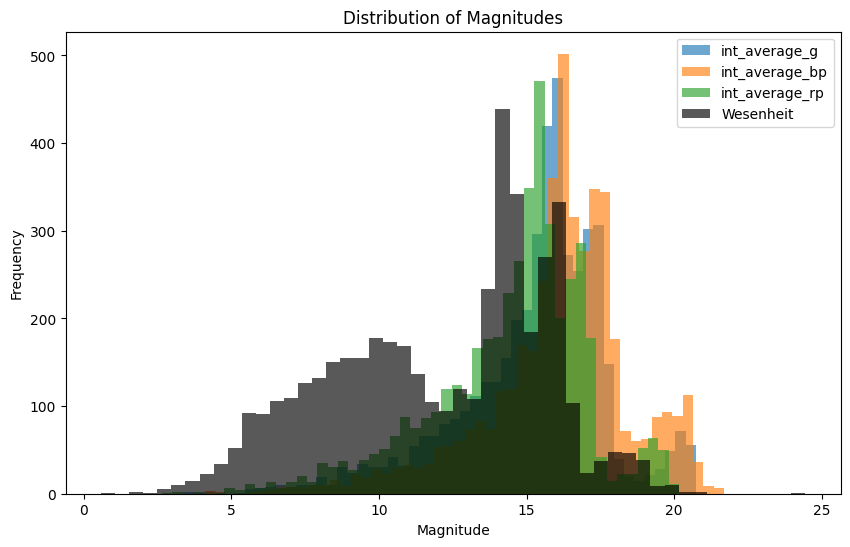

In [ ]:
import matplotlib.pyplot as plt

# Create the histogram plot
plt.figure(figsize=(10, 6))

# Plot histograms for each magnitude
plt.hist(cepheid_types3['int_average_g'], bins=50, alpha=0.65, label='int_average_g')
plt.hist(cepheid_types3['int_average_bp'], bins=50, alpha=0.65, label='int_average_bp')
plt.hist(cepheid_types3['int_average_rp'], bins=50, alpha=0.65, label='int_average_rp')
plt.hist(cepheid_types3['Wesenheit'], bins=50, alpha=0.65, label='Wesenheit', color='black')

# Add legend and labels
plt.legend()
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.title('Distribution of Magnitudes')

# Show the plot
plt.show()

Now, use both the naive and Bailer-Jones distance estimates to determine the absolute Wesenheit magnitudes, $M_W$. Again, be sure to propagate the uncertainties. Add both columns to your dataframe. <font color='green'>**(1e)** Compare the two $M_W$ distributions using a histogram plot.</font>

In [ ]:
cepheid_types3['M_wesenheit_naive_distance'] = cepheid_types3['Wesenheit'] + 5 - 5*(np.log10(cepheid_types3['distance']))

# The formula being used here is  M = m + 5 - 5log(base10)(D) to calculate the absolute wesenheit magnitude. 'M_wesenheit_naive_distance' is the new column being added to our
# DataFrame and it represents the Absolute Wesenheit Magnitude calculated using the naive distances estimates.

cepheid_types3['M_Wesenheit_NaiveDistance_Error'] = np.sqrt((cepheid_types3['error_Wesenheit']**2) + ((np.log10((cepheid_types3['distance_error'])))**2)*(5/((cepheid_types3['distance']) - np.log(10))**2))

# Here, we are calculating or doing the error propagation for the Absolute Wesenheit Magnitude calculated using Naive estimate of distance and it is represented by the column
# 'M_Wesenheit_NaiveDistance_Error' which is being added to our DataFrame.

cepheid_types3['M_wesenheit_Bailer'] = cepheid_types3['Wesenheit'] + 5 - 5*(np.log10(cepheid_types3['r_med_geo']))

# The formula being used here is  M = m + 5 - 5log(base10)(D) to calculate the absolute wesenheit magnitude. 'M_wesenheit_Bailer' is the new column being added to our DataFrame
# and it represents the Absolute Wesenheit Magnitude calculated using the Bailer-Jones distances estimates.

cepheid_types3['M_wesenheit_BailerError'] = np.sqrt((cepheid_types3['error_Wesenheit']**2) + (np.log10((cepheid_types3['r_lo_geo'] + cepheid_types3['r_hi_geo'])/2)**2)*(5/((cepheid_types3['r_med_geo']) - np.log(10))**2))

# The error in the value for Absolute Wesenheit Magnitude calculated using Bailer-Jones distance estimates is equal to the error in Wesenheit magnitude + the average
# of the two standard deviations which are 'r_lo_geo' and 'r_hi_geo' to find out what the actual standard deviation is.
# This is because according to the rules for calculating the error, we are supposed to add the errors in Wesenheit Magnitude and r_med_geo and
# the average of the lower bound and upper bound values would give us our accurate error in r_med_geo.


print(cepheid_types3)

                 source_id     r_med_geo      r_lo_geo      r_hi_geo   flag  \
4      4658039710832195200   7754.655273   6408.205078   9781.739258  10022   
7      4658041707905510912  10721.492188   8229.466797  13522.274414  10033   
8      4658042287684443648  17435.130859  13831.750000  22782.642578  10023   
12     4658044869001119104  19229.738281  16250.982422  22916.783203  10033   
13     4658046002872198528  13338.875000  10274.221680  16600.832031  10033   
...                    ...           ...           ...           ...    ...   
14982  2018778051011957376   7141.135742   6071.462891   9097.218750  10033   
14984  2018900951456670208   9930.901367   8133.830078  12532.222656  10033   
14985  6666081030586994304   8112.983398   6879.636719   9871.663086  10033   
14986  4070454413368471040   6607.472168   5367.879395   8654.468750  10033   
14990  3329849043206545920   2463.379395   2347.978760   2566.502441  10033   

               ra        dec           L          B

<ipython-input-20-0be5a1411067>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cepheid_types3['M_wesenheit_naive_distance'] = cepheid_types3['Wesenheit'] + 5 - 5*(np.log10(cepheid_types3['distance']))
<ipython-input-20-0be5a1411067>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cepheid_types3['M_Wesenheit_NaiveDistance_Error'] = np.sqrt((cepheid_types3['error_Wesenheit']**2) + ((np.log10((cepheid_types3['distance_error'])))**2)*(5/((cepheid_types3['distance']) - np.log(10))**2))
<ipython-input-20-0be5a

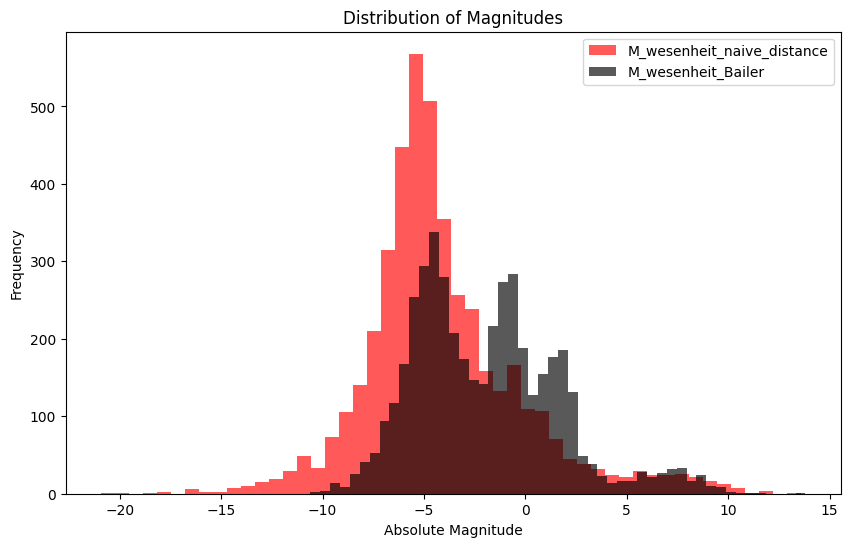

In [ ]:
import matplotlib.pyplot as plt

# Create the histogram plot
plt.figure(figsize=(10, 6))

# Plot histograms for each magnitude
plt.hist(cepheid_types3['M_wesenheit_naive_distance'], bins=50, alpha=0.65, label='M_wesenheit_naive_distance', color='red')
plt.hist(cepheid_types3['M_wesenheit_Bailer'], bins=50, alpha=0.65, label='M_wesenheit_Bailer', color='black')

# Add legend and labels
plt.legend()
plt.xlabel('Absolute Magnitude')
plt.ylabel('Frequency')
plt.title('Distribution of Magnitudes')

# Show the plot
plt.show()

## 1.7 Plotting the $M_W$-Period Relation (PWR).

<font color='green'>**(1f)** Plot a scatter plot of $log_{10} P$ versus $M_W$ , where $P$ is the period in days for both distance estimates.</font> Be sure to get your y-axis right -- brightness should increase towards the top of the diagram.

<font color='green'>**(1g)** Describe what you see in the plots. Does it make sense? How does the PWR compare for the two distance estimates?</font>

<font color='green'>**(1h)** Try filtering your catalogue to include only those objects with ratios of parallax/parallax-error > 5. You can try other values, too. Describe the how changing the parallax-to-parallax-error cut modifies the appearance of the PWR plots. </font>


In [ ]:
cepheid_types3['Log10(P)'] = np.log10(cepheid_types3['pf'])

# Since we are supposed to plot a scatterplot of Log to the base 10 of the period which in our DataFrame is 'pf' versus the Absolute Wesenheit Magnitude calculated using
# both the distance estimates, we add a new column to our DataFrame with the name 'Log10(P)' which contains the values of the Log to the base 10 of 'pf' as denoted by the
# code 'np.log10(cepheid_types3['pf'])'. So, in easy terms, cepheid_types3['Log10(P)'] = Log10('pf').

print(cepheid_types3)

                 source_id     r_med_geo      r_lo_geo      r_hi_geo   flag  \
4      4658039710832195200   7754.655273   6408.205078   9781.739258  10022   
7      4658041707905510912  10721.492188   8229.466797  13522.274414  10033   
8      4658042287684443648  17435.130859  13831.750000  22782.642578  10023   
12     4658044869001119104  19229.738281  16250.982422  22916.783203  10033   
13     4658046002872198528  13338.875000  10274.221680  16600.832031  10033   
...                    ...           ...           ...           ...    ...   
14982  2018778051011957376   7141.135742   6071.462891   9097.218750  10033   
14984  2018900951456670208   9930.901367   8133.830078  12532.222656  10033   
14985  6666081030586994304   8112.983398   6879.636719   9871.663086  10033   
14986  4070454413368471040   6607.472168   5367.879395   8654.468750  10033   
14990  3329849043206545920   2463.379395   2347.978760   2566.502441  10033   

               ra        dec           L          B

<ipython-input-22-8d7c048eae46>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cepheid_types3['Log10(P)'] = np.log10(cepheid_types3['pf'])


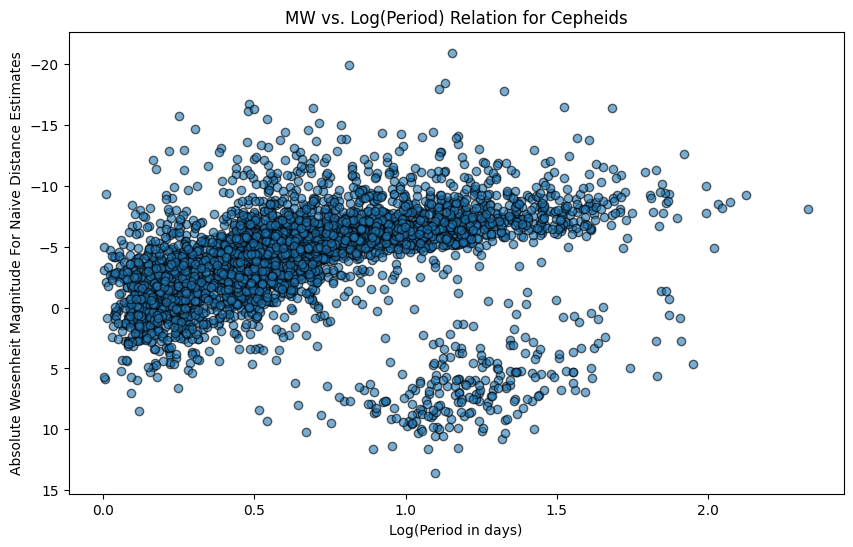

In [ ]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(cepheid_types3['Log10(P)'], cepheid_types3['M_wesenheit_naive_distance'], edgecolor='k', alpha=0.6)

# This line creates a scatter plot using the 'Log10(P)' column in our DataFrame which goes along the x-axis and the Absolute Wesenheit Magnitude calculated using
# Naive Distance estimates which goes along the y-axis.

# Since the y-axis should show brighter stars at the top, invert the y-axis
plt.gca().invert_yaxis()

# We invert the y-axis because the Absolute Wesenheit Magnitude is being represented on the y-axis and the lower the value of the Magnitude, the brighter the star.
# We want the y-axis to show the brighter stars on the top.

# Add labels and title
plt.xlabel('Log(Period in days)')
plt.ylabel('Absolute Wesenheit Magnitude For Naive Distance Estimates')
plt.title('MW vs. Log(Period) Relation for Cepheids')

# Show the plot
plt.show()

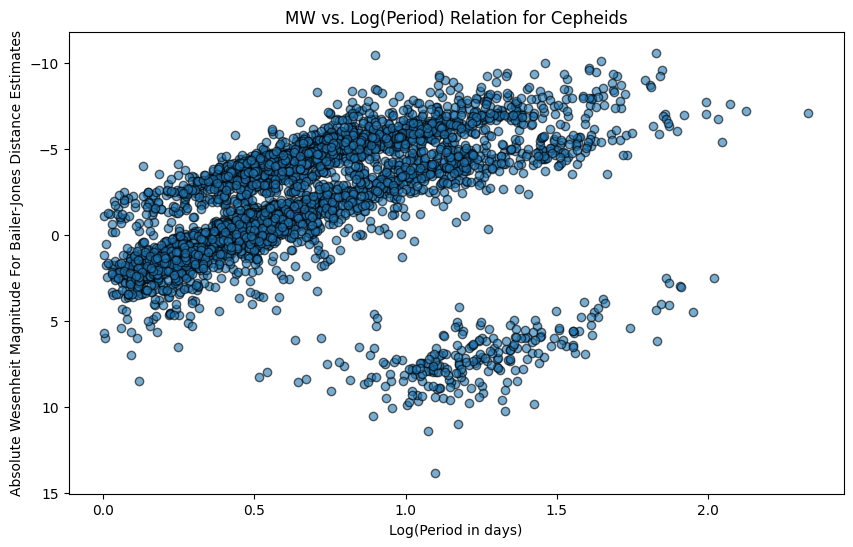

In [ ]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(cepheid_types3['Log10(P)'], cepheid_types3['M_wesenheit_Bailer'], edgecolor='k', alpha=0.6)

# This line creates a scatter plot using the 'Log10(P)' column in our DataFrame which goes along the x-axis and the Absolute Wesenheit Magnitude calculated using
# Bailer-Jones Distance estimates which goes along the y-axis.

# Since the y-axis should show brighter stars at the top, invert the y-axis
plt.gca().invert_yaxis()

# Add labels and title
plt.xlabel('Log(Period in days)')
plt.ylabel('Absolute Wesenheit Magnitude For Bailer-Jones Distance Estimates')
plt.title('MW vs. Log(Period) Relation for Cepheids')

# Show the plot
plt.show()

In [ ]:
cepheid_types3['Parallax_to_error_ratio'] = (cepheid_types3['parallax'])/(cepheid_types3['parallax_error'])

# Here, we are calculating the Parallax to Parallax error ratio which is also what the new column 'Parallax_to_error_ratio' in our DataFrame represents.

print(cepheid_types3)

                 source_id     r_med_geo      r_lo_geo      r_hi_geo   flag  \
4      4658039710832195200   7754.655273   6408.205078   9781.739258  10022   
7      4658041707905510912  10721.492188   8229.466797  13522.274414  10033   
8      4658042287684443648  17435.130859  13831.750000  22782.642578  10023   
12     4658044869001119104  19229.738281  16250.982422  22916.783203  10033   
13     4658046002872198528  13338.875000  10274.221680  16600.832031  10033   
...                    ...           ...           ...           ...    ...   
14982  2018778051011957376   7141.135742   6071.462891   9097.218750  10033   
14984  2018900951456670208   9930.901367   8133.830078  12532.222656  10033   
14985  6666081030586994304   8112.983398   6879.636719   9871.663086  10033   
14986  4070454413368471040   6607.472168   5367.879395   8654.468750  10033   
14990  3329849043206545920   2463.379395   2347.978760   2566.502441  10033   

               ra        dec           L          B

<ipython-input-25-14fbdbc43a0d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cepheid_types3['Parallax_to_error_ratio'] = (cepheid_types3['parallax'])/(cepheid_types3['parallax_error'])


In [ ]:
# We filter out rows where the parallax is less than or equal to zero
cepheid_types4 = cepheid_types3[cepheid_types3['Parallax_to_error_ratio'] > 5]

# 'cepheid_types4' now is our new filtered DataFrame which contains only those values of Parallax to Parallax error ratio which are greater than 5.

print(cepheid_types4)

                 source_id    r_med_geo     r_lo_geo     r_hi_geo   flag  \
99     5313185367659966720  4974.366211  4725.388184  5264.668457  10033   
100    5313250548085699712  5156.596191  4637.579590  5590.342285  10033   
120    2161786374436607616  1209.748535  1182.494263  1237.511353  10033   
232    5436296928693979392  3175.371582  3046.474365  3333.781006  10033   
244    6060173364074372352   748.439087   737.540161   759.456421  10033   
...                    ...          ...          ...          ...    ...   
14942  2015458213056909184  5040.499512  4715.431152  5281.997070  10033   
14945  2015622212085282048  3398.958984  3227.939209  3606.861572  10033   
14946  2015820463470505600  1572.720581  1537.978149  1604.739258  10033   
14954  4253603501158148736  2265.836426  2188.910645  2343.673828  10033   
14990  3329849043206545920  2463.379395  2347.978760  2566.502441  10033   

               ra        dec           L          B  parallax  ...  \
99     140.707495

<font color='green'>**(1i)** Explore your data -- are the results as expected? Perform any further filtering required to refine the selection and explain why you've made these cuts (hint: generate a scatterplot of the data in Galactic coodinates (l, b) -- you can use different colours to highlight different groupings identified in your PWR).</font>

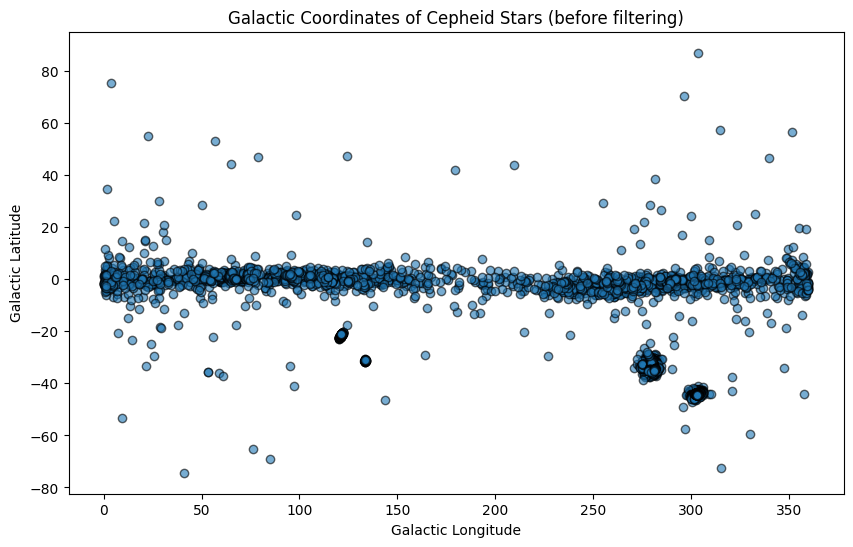

In [ ]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(cepheid_types3['L'], cepheid_types3['B'], edgecolor='k', alpha=0.6)

# This plots a scatterplot using the two columns in our DataFrame, The Galactic Longitude denoted by 'L' along the x-axis and The Galactic Latitude denoted by 'B'
# along the y-axis. Also, it can be noticed that we are using the unfiltered DataFrame 'cepheid_types3' here. This is just being done to show the difference in the
# scatterplots plotted using the galactic coordinates before and after the filtering of the Parallax to Parallax error ratio is done.

# Add labels and title
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')
plt.title('Galactic Coordinates of Cepheid Stars (before filtering)')

# Show the plot
plt.show()

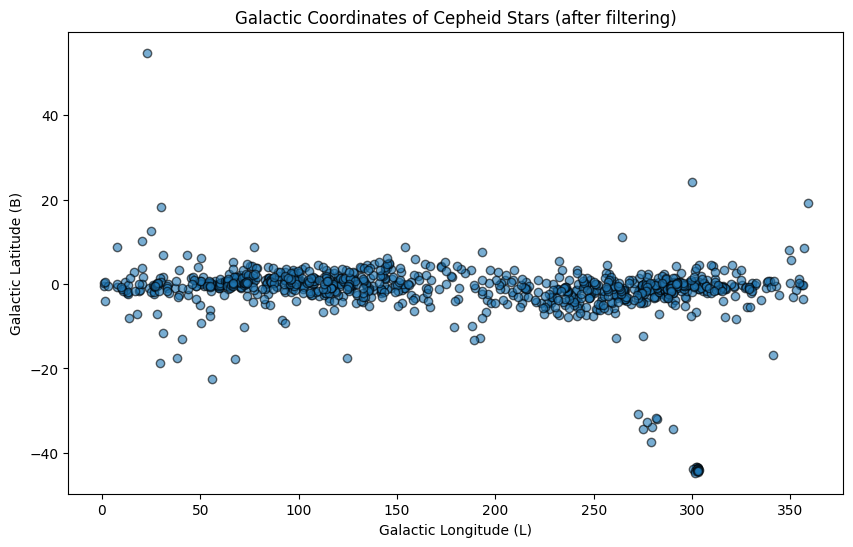

In [ ]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(cepheid_types4['L'], cepheid_types4['B'], edgecolor='k', alpha=0.6)

# This plots a scatterplot using the two columns in our DataFrame, The Galactic Longitude denoted by 'L' along the x-axis and The Galactic Latitude denoted by 'B'
# along the y-axis. Here we use the filtered DataFrame 'cepheid_types4'.

# Add labels and title
plt.xlabel('Galactic Longitude (L)')
plt.ylabel('Galactic Latitude (B)')
plt.title('Galactic Coordinates of Cepheid Stars (after filtering)')

# Show the plot
plt.show()


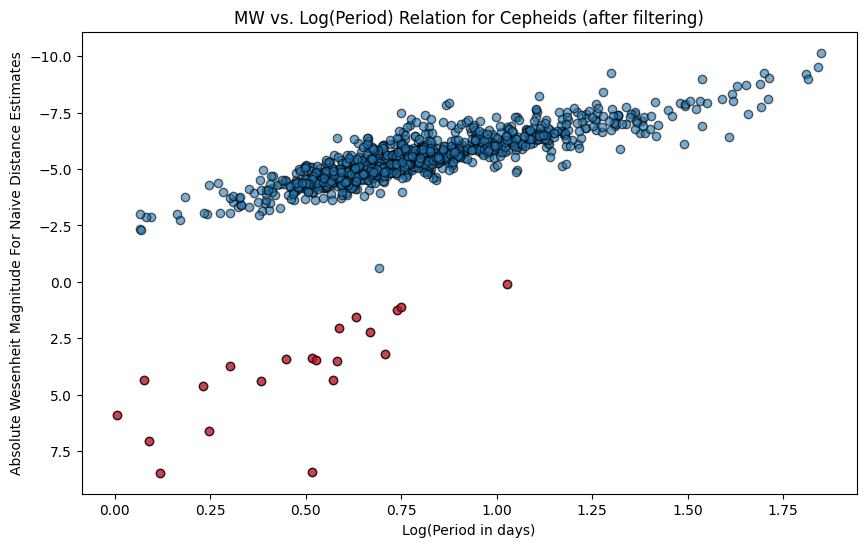

In [ ]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(cepheid_types4['Log10(P)'], cepheid_types4['M_wesenheit_naive_distance'], edgecolor='k', alpha=0.6)

# Separate the data based on the condition
condition = cepheid_types4['M_wesenheit_naive_distance'] > 0
AbsoluteMagnitude_above_zero = cepheid_types4[condition]

# this line filters the DataFrame cephied_types4 to include only those rows where the 'M_wesenheit_naive_distance' is greater than 0.
# This filtered DataFrame is stored in AbsoluteMagnitude_above_zero.

# Plot the points with y > 0 in the original color, e.g., blue
plt.scatter(AbsoluteMagnitude_above_zero['Log10(P)'], AbsoluteMagnitude_above_zero['M_wesenheit_naive_distance'],
            edgecolor='k', alpha=0.6, color='red', label='y > 0')

# Using this line of code, we are trying to assign a different colour to those data points that have a value of 'M_wesenheit_naive_distance' greater than 0.

# Since the y-axis should show brighter stars at the top, invert the y-axis
plt.gca().invert_yaxis()

# Add labels and title
plt.xlabel('Log(Period in days)')
plt.ylabel('Absolute Wesenheit Magnitude For Naive Distance Estimates')
plt.title('MW vs. Log(Period) Relation for Cepheids (after filtering)')

# Show the plot
plt.show()

# We are plotting the PWR scatterplot for the Absolute Wesenheit Magnitude calculated using the Naive Distance estimates but this time we are using our filtered
# DataFrame 'cepheid_types4' to portray the difference in the plot after the Parallax to Parallax error filtering is done.

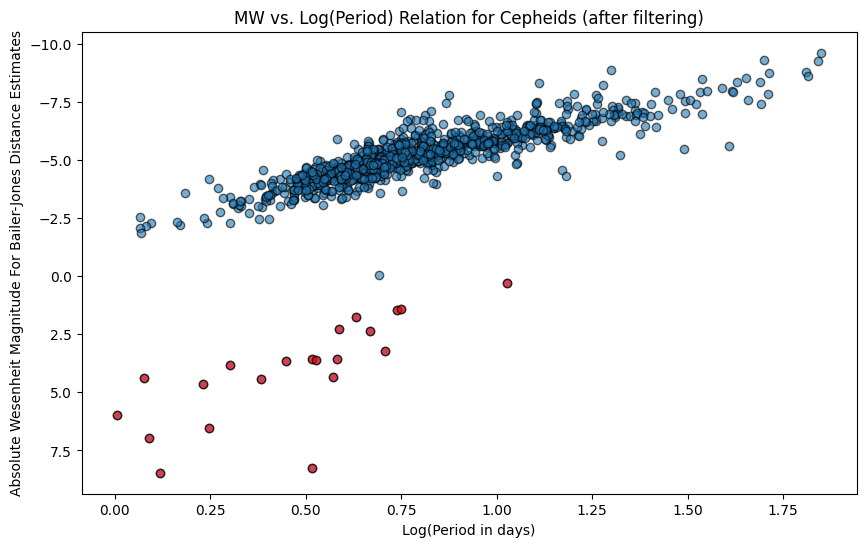

In [ ]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(cepheid_types4['Log10(P)'], cepheid_types4['M_wesenheit_Bailer'], edgecolor='k', alpha=0.6)

# Separate the data based on the condition
condition = cepheid_types4['M_wesenheit_Bailer'] >= 0
AbsoluteMagnitude2_above_zero = cepheid_types4[condition]

# this line filters the DataFrame cephied_types4 to include only those rows where the 'M_wesenheit_Bailer' is greater than 0.
# This filtered DataFrame is stored in AbsoluteMagnitude2_above_zero.

# Plot the points with y > 0 in the original color, e.g., blue
plt.scatter(AbsoluteMagnitude2_above_zero['Log10(P)'], AbsoluteMagnitude2_above_zero['M_wesenheit_Bailer'],
            edgecolor='k', alpha=0.6, color='red', label='y > 0')

# Using this line of code, we are trying to assign a different colour to those data points that have a value of 'M_wesenheit_Bailer' greater than 0.

# Since the y-axis should show brighter stars at the top, invert the y-axis
plt.gca().invert_yaxis()

# Add labels and title
plt.xlabel('Log(Period in days)')
plt.ylabel('Absolute Wesenheit Magnitude For Bailer-Jones Distance Estimates')
plt.title('MW vs. Log(Period) Relation for Cepheids (after filtering)')

# Show the plot
plt.show()

# We are plotting the PWR scatterplot for the Absolute Wesenheit Magnitude calculated using the Bailer-Jones Distance estimates but this time we are using our filtered
# DataFrame 'cepheid_types4' to portray the difference in the plot after the Parallax to Parallax error filtering is done.

***
# <font color='red'> You should aim to get to here by the end of the lab in week 3! </font> #
***

# Part 2: Fitting a straight line to the PWR

With our filtered catalogue in hand, we are now in a position to fit the PWR using a straight-line model (i.e., polynomial with order 1). To do this, we will first use standard optimisation, and then we will use MCMC, which explores the parameter space more thoroughly and provides best fit estimates for the parameters and their associated uncertainties.

## 2.1 Setting up for the fitting
To begin, you need to write a function that returns a straight line given a set of parameters, $p$, and an $x$-coordinate. You can look back at the Lectorial notebooks for inspiration!

Be sure to test your function by generating fake x-values and plotting the results for a set of parameters.

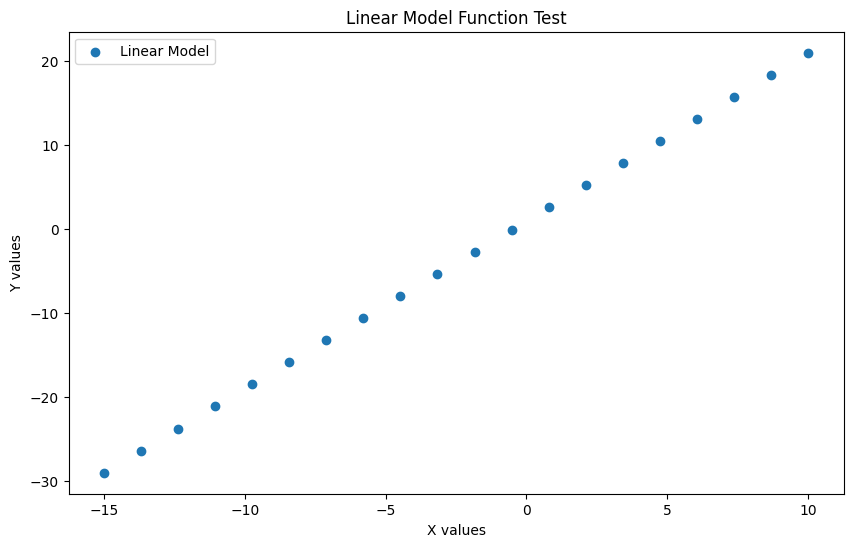

In [ ]:
def PolyModel(p, x):
    """
    Returns a straight line y = mx + b

    Parameters:
    - x: Independent variable.
    - p: Parameters of the model (m, b).

    Returns:
    - y: Dependent variable calculated from the linear model.
    """
    m, b = p
    y = m * x + b
    return y

# Example usage:
p = (2, 1)  # Example parameters with m=2 and b=1
x = np.linspace(start=-15, stop=10, num=20)  # Generate 20 x-values from -15 to 10
y = PolyModel(p, x)  # Calculate corresponding y-values using the model

# Plot the results to test
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='Linear Model')
plt.legend()
plt.xlabel('X values')
plt.ylabel('Y values')
plt.title('Linear Model Function Test')
plt.show()

Now, define a function that returns the $\chi^2$ for a given set of parameters, $p$, and data points $x, y$ and the uncertainty associated with the $y-$values, $\sigma_y$. We will assume that the uncertainties on the $x-$values are very small, and can therefore be ignored.

In [ ]:
def chisq(p, xData, yData, sigma_yData):
    """
    Function to evaluate chi-Squared given parameters and data
    """

    # Calculate the y values at the given x values
    yModel = PolyModel(p,xData)

    # Calculate chi-squared value
    chisqValue = np.sum( ((yModel - yData) / sigma_yData)**2 )

    return chisqValue

## 2.2 Running the fit
We are now ready to fit the data. Use the fmin function from scipy.optimize to run a simple fit to both PWRs. Don't forget to determine initial estimates for your parameters -- these are required as input to the optimiser.

Run fits for several different cuts in parallax-to-parallax-error ratios. <font color='green'>**(2a)** Compare your results using plots and quantitative assessment. One way to quantitatively compare the fidelity of the PWR for the naive and Bailer-Jones distance estimates is to examine the residuals in the $y-$data after subtracting the best-fitting model predicted for the $x-$value. You can plot the histogram of the residuals, which should resemble a Gaussian distribution. You can determine the median and spread (using numpy percentiles, or the mean and standard deviation) for the distribution in order to understand if there is a lower overall scatter for a given distance estimate. How do these values change with changing parallax-to-parallax-error ratios?</font>

<font color='green'>**(2b)** Choose a sensible value to filter your catalogue that is based on the results for different parallax-to-parallax-error values. </font>

Optimization terminated successfully.
         Current function value: 6828240.186350
         Iterations: 88
         Function evaluations: 167
Best fit parameters: slope = -3.7868400502792197, intercept = -2.497504503829491


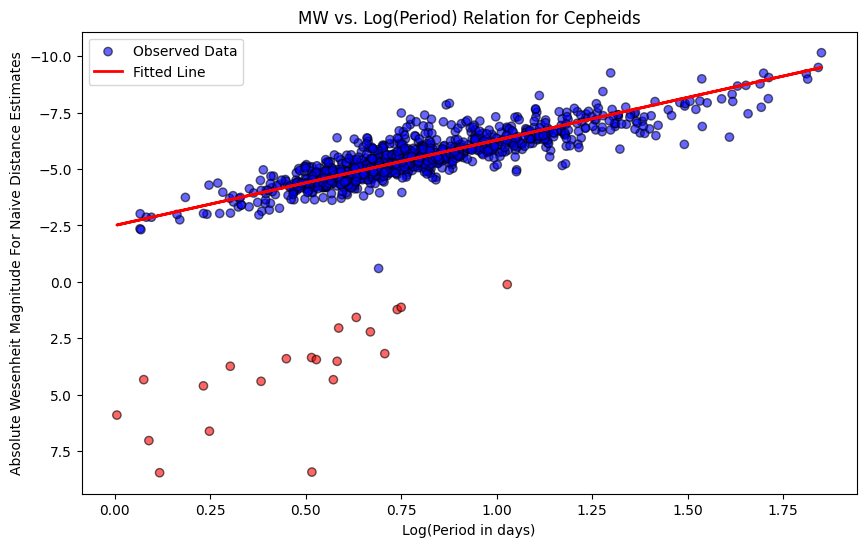

In [ ]:
from scipy.optimize import fmin

xData = np.array(cepheid_types4['Log10(P)'])
yData = np.array(cepheid_types4['M_wesenheit_naive_distance'])
sigma_yData = np.array(cepheid_types4['M_Wesenheit_NaiveDistance_Error'])

# These represent the x-values, y-values, and uncertainties of the y-values, respectively.

# Define the model function that returns the straight line
def PolyModel(p, x):
    m, b = p
    return m * x + b

# Define the chi-squared function
def chisq(p, x, y, sigma_y):
    yModel = PolyModel(p, x)
    chi_sq = np.sum(((yModel - y) / sigma_y) ** 2)
    return chi_sq

# Define the fitting function for fmin
def fit_function(p, x, y, sigma_y):
    return chisq(p, x, y, sigma_y)

# Wraps the chisq function to be used by the fmin optimizer.

# Initial guess for the parameters: slope (m) and intercept (b)
initial_parameters = [1, 0]

# Perform the optimization to minimize the chi-squared value
best_parameters = fmin(fit_function, initial_parameters, args=(cepheid_types4['Log10(P)'], cepheid_types4['M_wesenheit_naive_distance'], cepheid_types4['M_Wesenheit_NaiveDistance_Error']), disp=True)
# The fmin function is called with the fitting function, the initial guess, and the data arrays. It minimizes the chi-squared value to find the best-fit parameters.

# Output the best fit parameters
print(f"Best fit parameters: slope = {best_parameters[0]}, intercept = {best_parameters[1]}")

# Calculate model values with the best-fit parameters
fitted_y = PolyModel(best_parameters, cepheid_types4['Log10(P)'])

# Computes the expected y-values (fitted_y) using the PolyModel function and the best-fit parameters.

# Now we can plot the data and the best fit line
import matplotlib.pyplot as plt

# Plot points with y > 0 in red, and the rest in blue
colors = ['red' if y > 0 else 'blue' for y in yData]

plt.figure(figsize=(10, 6))
plt.scatter(xData, yData, c = colors, label='Observed Data', alpha=0.6, edgecolor='k')
plt.plot(xData, fitted_y, 'r-', label='Fitted Line', linewidth=2)
plt.xlabel('Log(Period in days)')
plt.ylabel('Absolute Wesenheit Magnitude For Naive Distance Estimates')
plt.title('MW vs. Log(Period) Relation for Cepheids')
plt.gca().invert_yaxis()  # Invert the y-axis to show brighter stars at the top
plt.legend()
plt.show()

Optimization terminated successfully.
         Current function value: 5842377.610811
         Iterations: 85
         Function evaluations: 154
Best fit parameters: slope = -4.000148764171183, intercept = -2.0977551479035665


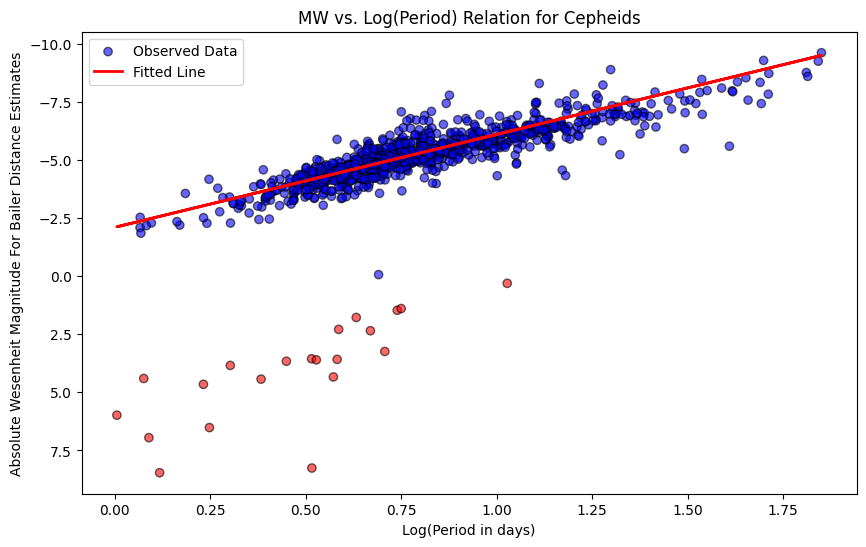

In [ ]:
from scipy.optimize import fmin

xData = np.array(cepheid_types4['Log10(P)'])
yData = np.array(cepheid_types4['M_wesenheit_Bailer'])
sigma_yData = np.array(cepheid_types4['M_wesenheit_BailerError'])

# These represent the x-values, y-values, and uncertainties of the y-values, respectively.

# Define the model function that returns the straight line
def PolyModel(p, x):
    m, b = p
    return m * x + b

# Define the chi-squared function
def chisq(p, x, y, sigma_y):
    yModel = PolyModel(p, x)
    chi_sq = np.sum(((yModel - y) / sigma_y) ** 2)
    return chi_sq

# Define the fitting function for fmin
def fit_function(p, x, y, sigma_y):
    return chisq(p, x, y, sigma_y)

# Wraps the chisq function to be used by the fmin optimizer.

# Initial guess for the parameters: slope (m) and intercept (b)
initial_parameters = [1, 0]

# Perform the optimization to minimize the chi-squared value
best_parameters = fmin(fit_function, initial_parameters, args=(cepheid_types4['Log10(P)'], cepheid_types4['M_wesenheit_Bailer'], cepheid_types4['M_wesenheit_BailerError']), disp=True)
# The fmin function is called with the fitting function, the initial guess, and the data arrays. It minimizes the chi-squared value to find the best-fit parameters.

# Output the best fit parameters
print(f"Best fit parameters: slope = {best_parameters[0]}, intercept = {best_parameters[1]}")

# Calculate model values with the best-fit parameters
fitted_y = PolyModel(best_parameters, cepheid_types4['Log10(P)'])

# Computes the expected y-values (fitted_y) using the PolyModel function and the best-fit parameters.

# Now we can plot the data and the best fit line
import matplotlib.pyplot as plt

# Plot points with y > 0 in red, and the rest in blue
colors = ['red' if y > 0 else 'blue' for y in yData]

plt.figure(figsize=(10, 6))
plt.scatter(xData, yData, c = colors, label='Observed Data', alpha=0.6, edgecolor='k')
plt.plot(xData, fitted_y, 'r-', label='Fitted Line', linewidth=2)
plt.xlabel('Log(Period in days)')
plt.ylabel('Absolute Wesenheit Magnitude For Bailer Distance Estimates')
plt.title('MW vs. Log(Period) Relation for Cepheids')
plt.gca().invert_yaxis()  # Invert the y-axis to show brighter stars at the top
plt.legend()
plt.show()

Optimization terminated successfully.
         Current function value: 6828240.186350
         Iterations: 88
         Function evaluations: 167
Ratio > 5: Mean of residuals = 0.20864237966950075, Std of residuals = 1.3266921156334053, Median of residuals = 0.10962358958176299
Optimization terminated successfully.
         Current function value: 2082352.001939
         Iterations: 94
         Function evaluations: 173
Ratio > 10: Mean of residuals = 0.024196451848243747, Std of residuals = 0.5276593719274956, Median of residuals = 0.032855110087814055
Optimization terminated successfully.
         Current function value: 768627.480487
         Iterations: 82
         Function evaluations: 153
Ratio > 15: Mean of residuals = 0.051908834207413414, Std of residuals = 0.4357071815783587, Median of residuals = 0.05327348399311305


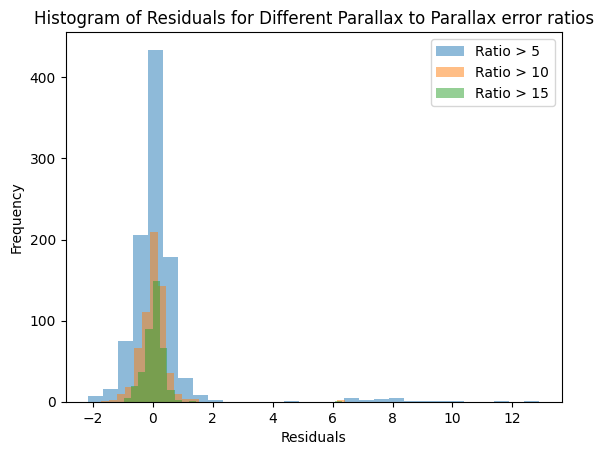

In [ ]:
# 1. Run fits for different cuts in parallax-to-parallax-error ratios
ratios = [5, 10, 15]

for ratio in ratios:
    # Filter the data based on the current ratio
    cepheid_types5 = cepheid_types4[cepheid_types4['Parallax_to_error_ratio'] > ratio]

    # 'cepheid_types5' is the new filtered DataFrame

    # For each ratio value, this loop filters cepheid_types4 dataframe to include only those rows where the
    # Parallax_to_error_ratio is greater than the current ratio being considered. It stores the filtered data in cepheid_types5.

    # Fit the filtered data
    xData = np.array(cepheid_types5['Log10(P)'])
    yData = np.array(cepheid_types5['M_wesenheit_naive_distance'])
    sigma_yData = np.array(cepheid_types5['M_Wesenheit_NaiveDistance_Error'])

    # These lines create numpy arrays from the dataframe columns that will be used for fitting.

    # Initial guess and fitting as before
    initial_parameters = [1, 0]
    best_parameters = fmin(fit_function, initial_parameters, args=(cepheid_types5['Log10(P)'], cepheid_types5['M_wesenheit_naive_distance'], cepheid_types5['M_Wesenheit_NaiveDistance_Error']), disp=True)

    # Calculate the residuals
    fitted_y = PolyModel(best_parameters, xData)
    residuals = yData - fitted_y

    # Using the best parameters found from the fit, this computes the model y values and calculates the residuals,
    # which are the differences between the observed data points and the fitted model.

    # 3. Plot the histogram of residuals for the current cut
    plt.hist(residuals, bins=30, alpha=0.5, label=f'Ratio > {ratio}')

    # 4. Calculate and print statistical measures
    mean_resid = np.mean(residuals)
    std_resid = np.std(residuals)
    median_resid = np.median(residuals)
    print(f'Ratio > {ratio}: Mean of residuals = {mean_resid}, Std of residuals = {std_resid}, Median of residuals = {median_resid}')

    # Here, the mean and standard deviation of the residuals are calculated and printed

    # Each iteration of the loop runs the fitting process for the different cut-off values in 'ratios'.

# Finalize histogram plot
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals for Different Parallax to Parallax error ratios')
plt.legend()
plt.show()

Optimization terminated successfully.
         Current function value: 5842377.610811
         Iterations: 85
         Function evaluations: 154
Ratio > 5: Mean of residuals = 0.2573420929756353, Std of residuals = 1.2874778032901208, Median of residuals = 0.10837470771312852
Optimization terminated successfully.
         Current function value: 1690990.654299
         Iterations: 85
         Function evaluations: 159
Ratio > 10: Mean of residuals = 0.021539572209211714, Std of residuals = 0.5097122094867201, Median of residuals = 0.016452106395328236
Optimization terminated successfully.
         Current function value: 537571.467648
         Iterations: 84
         Function evaluations: 161
Ratio > 15: Mean of residuals = 0.03314620052544358, Std of residuals = 0.4248002972624058, Median of residuals = 0.03239262148584743


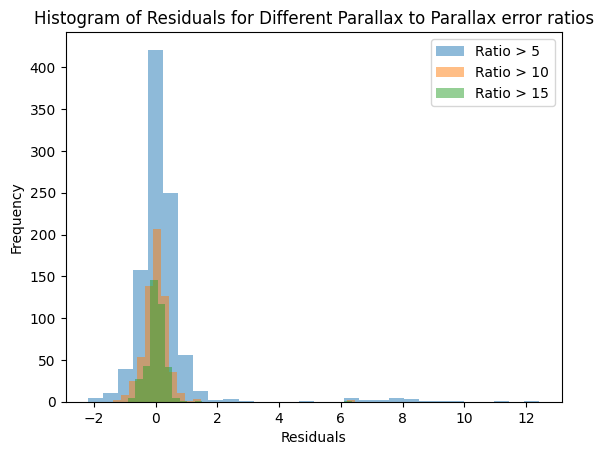

In [ ]:
# 1. Run fits for different cuts in parallax-to-parallax-error ratios
ratios = [5, 10, 15]
for ratio in ratios:
    # Filter the data based on the current ratio
    cepheid_types5 = cepheid_types4[cepheid_types4['Parallax_to_error_ratio'] > ratio]

    # 'cepheid_types5' is the new filtered DataFrame.

    # Fit the filtered data
    xData = np.array(cepheid_types5['Log10(P)'])
    yData = np.array(cepheid_types5['M_wesenheit_Bailer'])
    sigma_yData = np.array(cepheid_types5['M_wesenheit_BailerError'])

    # Initial guess and fitting as before
    initial_parameters = [1, 0]
    best_parameters = fmin(fit_function, initial_parameters, args=(cepheid_types5['Log10(P)'], cepheid_types5['M_wesenheit_Bailer'], cepheid_types5['M_wesenheit_BailerError']), disp=True)

    # Calculate the residuals
    fitted_y = PolyModel(best_parameters, xData)
    residuals = yData - fitted_y

    # 3. Plot the histogram of residuals for the current cut
    plt.hist(residuals, bins=30, alpha=0.5, label=f'Ratio > {ratio}')

    # 4. Calculate and print statistical measures
    mean_resid = np.mean(residuals)
    std_resid = np.std(residuals)
    Median_resid = np.median(residuals)
    print(f'Ratio > {ratio}: Mean of residuals = {mean_resid}, Std of residuals = {std_resid}, Median of residuals = {Median_resid}')

# Finalize histogram plot
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals for Different Parallax to Parallax error ratios')
plt.legend()
plt.show()

# With this entire code, the same process as the previous code is being repeated except this time it is for Absolute Wesenheit Magnitude calculated using
# Bailer-Jones distance estimates.

## 2.3 Finalising the best fit parameters

When you plotted the residuals, you may have noticed that there were outliers that were more than $3\sigma$ from the mean/median of the residuals. These outliers can affect the fits. There are several methods by which we can account for these outliers in order to minimise their impact on the fits. Here, we will simply filter those datapoints and refit.

Using your sample filtered for parallax-to-parallax-error (with your chosen value above), determine which of the objects are outliers (i.e., they are further than $3\sigma$ from the mean/median of the distribution of residuals), and filter those objects out of your sample. Refit both PWRs using your newly cleaned sample. You may wish to repeat this process until all datapoints lie within $\pm 3\sigma$. <font color='green'> **(2c)** Plot the results of your new fits and compare with the original fit prior to filtering outliers. How do your new fits compare with the original fits?</font>

Optimization terminated successfully.
         Current function value: 688062.604443
         Iterations: 85
         Function evaluations: 162
Optimization terminated successfully.
         Current function value: 688062.604443
         Iterations: 85
         Function evaluations: 162


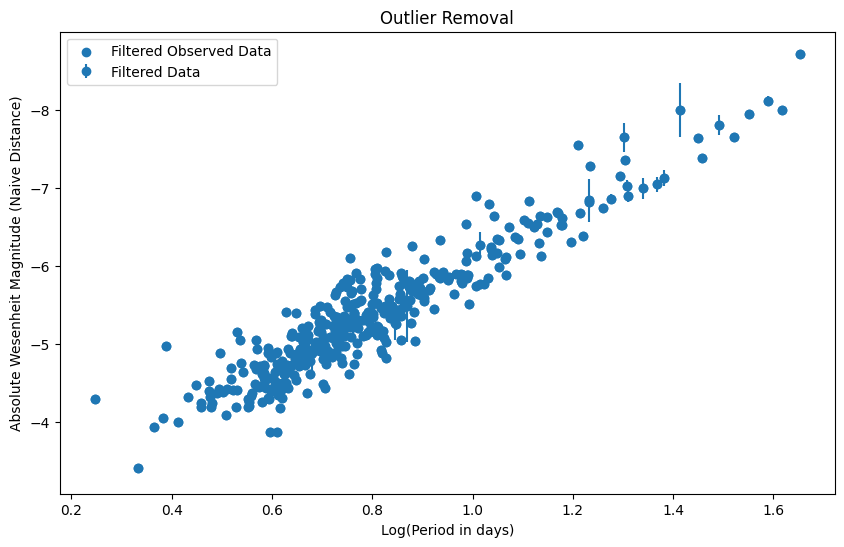

In [ ]:
import numpy as np
from scipy.optimize import fmin

mean_residuals = np.mean(residuals)

# This calculates the average of the residuals array, which represents the differences between observed data points and the values predicted by the model.

std_residuals = np.std(residuals)

# This calculates the standard deviation of the residuals array, which is a measure of the amount of variation or dispersion of the residuals.

# Find the outliers (more than 3 standard deviations from the mean)
outliers = np.abs(residuals - mean_residuals) > 3 * std_residuals

# This line identifies outliers in the data. It creates a Boolean array where each element is True if the
# corresponding residual is more than three standard deviations away from the mean residual.

# Remove outliers from our data
filtered_xData = cepheid_types5['Log10(P)'][~outliers]

# This filters out the outliers from the x-data. It selects only the entries of Log10(P) from the cepheid_types5 DataFrame where the corresponding outliers array is False.

filtered_yData = cepheid_types5['M_wesenheit_naive_distance'][~outliers] # this filters out the outliers from the y-data.
filtered_sigma_yData = cepheid_types5['M_Wesenheit_NaiveDistance_Error'][~outliers] # This line filters out the outliers from the uncertainties of the y-data.

# Refitting our model without the outliers
new_parameters = fmin(fit_function, initial_parameters, args=(filtered_xData, filtered_yData, filtered_sigma_yData), disp=True)

# This function refits the model using the filtered data that excludes outliers.

# Calculate the new fitted values
new_fitted_y = PolyModel(new_parameters, filtered_xData)

# Once the new best-fit parameters are found, this line calculates the y-values predicted by the model using these parameters and the filtered x-data.

# Plot the new fit and compare with the original fit
plt.figure(figsize=(10, 6))
plt.errorbar(filtered_xData, filtered_yData, yerr=filtered_sigma_yData, fmt='o', label='Filtered Data')

# This command creates an error bar plot. It plots the filtered x and y data points with error bars that represent the uncertainties in y.

# Now fit the model with the filtered data
new_best_parameters = fmin(fit_function, initial_parameters, args=(filtered_xData, filtered_yData, filtered_sigma_yData), disp=True)

# This finds the best-fit parameters for the model using the filtered data, excluding outliers.

# Use the new best parameters to calculate the new model values
new_fitted_y = PolyModel(new_best_parameters, filtered_xData)

# This uses the best-fit parameters to calculate the y-values of the fitted model across the filtered x-values

# Plot the new fit
plt.scatter(filtered_xData, filtered_yData, label='Filtered Observed Data')

# Invert the y-axis to show brighter stars at the top
plt.gca().invert_yaxis()

# Add labels and title
plt.xlabel('Log(Period in days)')
plt.ylabel('Absolute Wesenheit Magnitude (Naive Distance)')
plt.title('Outlier Removal')

# Show the legend and the plot
plt.legend()
plt.show()

Optimization terminated successfully.
         Current function value: 457111.112131
         Iterations: 80
         Function evaluations: 154
Optimization terminated successfully.
         Current function value: 457111.112131
         Iterations: 80
         Function evaluations: 154


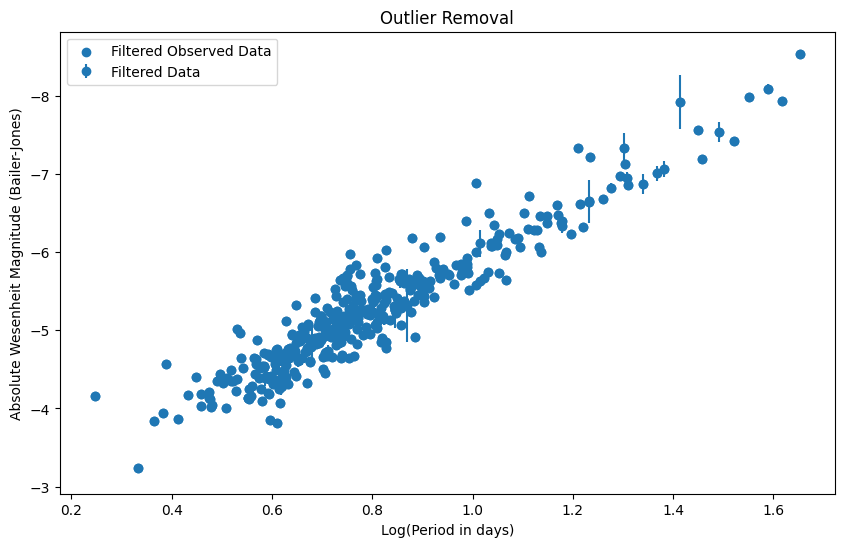

In [ ]:
import numpy as np
from scipy.optimize import fmin

mean_residuals = np.mean(residuals)
std_residuals = np.std(residuals)

# Find the outliers (more than 3 standard deviations from the mean)
outliers = np.abs(residuals - mean_residuals) > 3 * std_residuals

# Remove outliers from our data
filtered_xData = cepheid_types5['Log10(P)'][~outliers]
filtered_yData = cepheid_types5['M_wesenheit_Bailer'][~outliers]
filtered_sigma_yData = cepheid_types5['M_wesenheit_BailerError'][~outliers]

# Refitting our model without the outliers
new_parameters = fmin(fit_function, initial_parameters, args=(filtered_xData, filtered_yData, filtered_sigma_yData), disp=True)

# Calculate the new fitted values
new_fitted_y = PolyModel(new_parameters, filtered_xData)

# Plot the new fit and compare with the original fit
plt.figure(figsize=(10, 6))
plt.errorbar(filtered_xData, filtered_yData, yerr=filtered_sigma_yData, fmt='o', label='Filtered Data')

# Assume 'initial_parameters' have been set and 'fit_function' is defined as before
# Now fit the model with the filtered data
new_best_parameters = fmin(fit_function, initial_parameters, args=(filtered_xData, filtered_yData, filtered_sigma_yData), disp=True)

# Use the new best parameters to calculate the new model values
new_fitted_y = PolyModel(new_best_parameters, filtered_xData)

# Plot the new fit
plt.scatter(filtered_xData, filtered_yData, label='Filtered Observed Data')

# Invert the y-axis to show brighter stars at the top
plt.gca().invert_yaxis()

# Add labels and title
plt.xlabel('Log(Period in days)')
plt.ylabel('Absolute Wesenheit Magnitude (Bailer-Jones)')
plt.title('Outlier Removal')

# Show the legend and the plot
plt.legend()
plt.show()

# Here, the same process as that of the previous code is being repeated except it's for the outlier removal of the PWR with respect to the Bailer-Jones distance estimates.

Optimization terminated successfully.
         Current function value: 768627.480487
         Iterations: 82
         Function evaluations: 153
Best fit parameters: slope = -3.4556282479074993, intercept = -2.6508827693655457


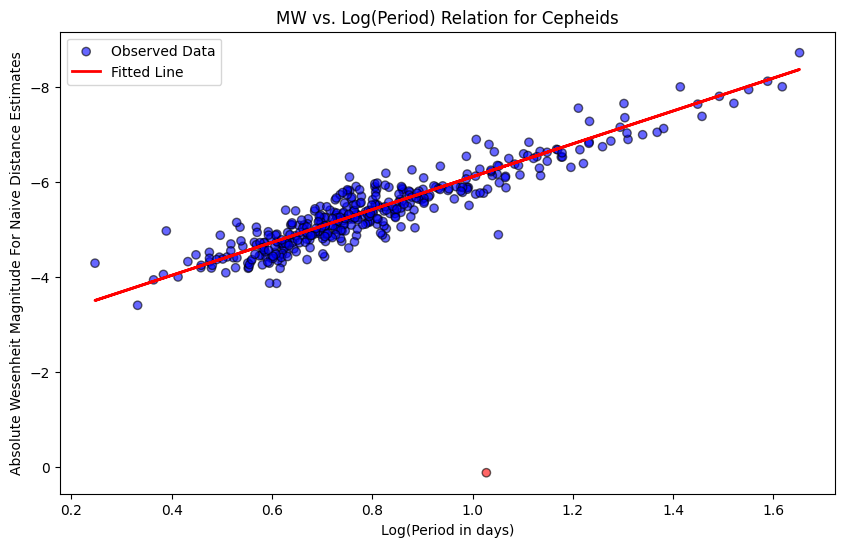

In [ ]:
# Now, using the functions we have defined so far and the new filtered data where the outliers have been removed, we plot the results of our
# new fit for the PWR with respect to the Naive Distance estimates in this code.

from scipy.optimize import fmin

xData = np.array(cepheid_types5['Log10(P)'])
yData = np.array(cepheid_types5['M_wesenheit_naive_distance'])
sigma_yData = np.array(cepheid_types5['M_Wesenheit_NaiveDistance_Error'])

# These represent the x-values, y-values, and uncertainties of the y-values, respectively.

# Define the model function that returns the straight line
def PolyModel(p, x):
    m, b = p
    return m * x + b

# Define the chi-squared function
def chisq(p, x, y, sigma_y):
    yModel = PolyModel(p, x)
    chi_sq = np.sum(((yModel - y) / sigma_y) ** 2)
    return chi_sq

# Define the fitting function for fmin
def fit_function(p, x, y, sigma_y):
    return chisq(p, x, y, sigma_y)

# Initial guess for the parameters: slope (m) and intercept (b)
initial_parameters = [1, 0]

# Perform the optimization to minimize the chi-squared value
best_parameters = fmin(fit_function, initial_parameters, args=(cepheid_types5['Log10(P)'], cepheid_types5['M_wesenheit_naive_distance'], cepheid_types5['M_Wesenheit_NaiveDistance_Error']), disp=True)

# The fmin function is called with the fitting function, the initial guess, and the data arrays. It minimizes the chi-squared value to find the best-fit parameters.


# Output the best fit parameters
print(f"Best fit parameters: slope = {best_parameters[0]}, intercept = {best_parameters[1]}")

# Calculate model values with the best-fit parameters
fitted_y = PolyModel(best_parameters, cepheid_types5['Log10(P)'])

# Computes the expected y-values (fitted_y) using the PolyModel function and the best-fit parameters.

# Now we can plot the data and the best fit line
import matplotlib.pyplot as plt

# Plot points with y > 0 in red, and the rest in blue
colors = ['red' if y > 0 else 'blue' for y in yData]

plt.figure(figsize=(10, 6))
plt.scatter(xData, yData, c = colors, label='Observed Data', alpha=0.6, edgecolor='k')
plt.plot(xData, fitted_y, 'r-', label='Fitted Line', linewidth=2)
plt.xlabel('Log(Period in days)')
plt.ylabel('Absolute Wesenheit Magnitude For Naive Distance Estimates')
plt.title('MW vs. Log(Period) Relation for Cepheids')
plt.gca().invert_yaxis()  # Invert the y-axis to show brighter stars at the top
plt.legend()
plt.show()

Optimization terminated successfully.
         Current function value: 537571.467648
         Iterations: 84
         Function evaluations: 161
Best fit parameters: slope = -3.3628365146964434, intercept = -2.5924090608946497


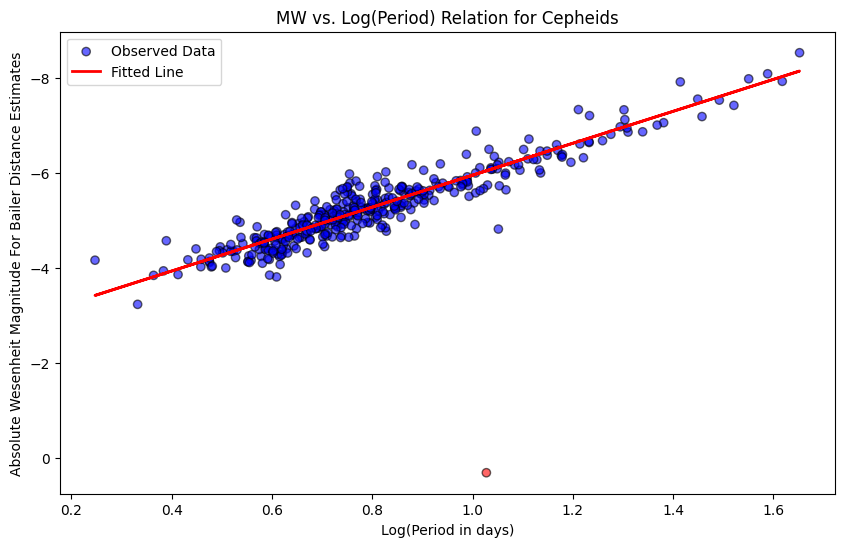

In [ ]:
# Now, using the functions we have defined so far and the new filtered data where the outliers have been removed, we plot the results of our
# new fit for the PWR with respect to the Bailer-Jones Distance estimates in this code.

from scipy.optimize import fmin

xData = np.array(cepheid_types5['Log10(P)'])
yData = np.array(cepheid_types5['M_wesenheit_Bailer'])
sigma_yData = np.array(cepheid_types5['M_wesenheit_BailerError'])

# Define the model function that returns the straight line
def PolyModel(p, x):
    m, b = p
    return m * x + b

# Define the chi-squared function
def chisq(p, x, y, sigma_y):
    yModel = PolyModel(p, x)
    chi_sq = np.sum(((yModel - y) / sigma_y) ** 2)
    return chi_sq

# Define the fitting function for fmin
def fit_function(p, x, y, sigma_y):
    return chisq(p, x, y, sigma_y)

# Initial guess for the parameters: slope (m) and intercept (b)
initial_parameters = [1, 0]

# Perform the optimization to minimize the chi-squared value
best_parameters2 = fmin(fit_function, initial_parameters, args=(cepheid_types5['Log10(P)'], cepheid_types5['M_wesenheit_Bailer'], cepheid_types5['M_wesenheit_BailerError']), disp=True)

# Output the best fit parameters
print(f"Best fit parameters: slope = {best_parameters2[0]}, intercept = {best_parameters2[1]}")

# Calculate model values with the best-fit parameters
fitted_y = PolyModel(best_parameters2, cepheid_types5['Log10(P)'])

# Now we can plot the data and the best fit line
import matplotlib.pyplot as plt

# Plot points with y > 0 in red, and the rest in blue
colors = ['red' if y > 0 else 'blue' for y in yData]

plt.figure(figsize=(10, 6))
plt.scatter(xData, yData, c = colors, label='Observed Data', alpha=0.6, edgecolor='k')
plt.plot(xData, fitted_y, 'r-', label='Fitted Line', linewidth=2)
plt.xlabel('Log(Period in days)')
plt.ylabel('Absolute Wesenheit Magnitude For Bailer Distance Estimates')
plt.title('MW vs. Log(Period) Relation for Cepheids')
plt.gca().invert_yaxis()  # Invert the y-axis to show brighter stars at the top
plt.legend()
plt.show()

***
# <font color='red'> You should aim to get to here by the end of the lab in week 4! </font> #
***

## 2.4 Using Markov Chain Monte Carlo (MCMC) sampling to determine best fit parameters and associated uncertainties.

We will now use an MCMC sampler to fit the straight line model to our data. Similar to that seen in lectorial 4, we will use a module called [emcee](https://emcee.readthedocs.io/en/stable/). This is a pure Python implementation of an MCMC sampler that makes many guesses in parallel.

First, you need to import emcee from the Imports folder.

Second, you need to define a function that now returns the log-likelihood, which will be maximised by the emcee sampler. Hint: recall $ln(\mathcal{L}) = -\chi^2/2.$

Once you have this set up, you can follow the procedure outlined in the Lectorial 4 notebook to run the MCMC sample, but modified for the simpler straight-line fit. <font color='white'> **(2d)** Produce plots that show how your chains evolve, and determine where convergence has occured.</font> Then, rerun your fit now starting at the final position of the first emcee run. <font color='white'> **(2e)** From this fit, determine the best fit parameters and their uncertainties using the flattened version of the chain for each fitted parameter. How do the MCMC fits compare with the fits determined by scipy.optimize.fmin?</font>

**1) Using the MCMC sampler for the Parameters (slope and intercept) of the fit for Absolute Wesenheit Magnitude calculated using Naive Distance Estimates against Log10(P)**

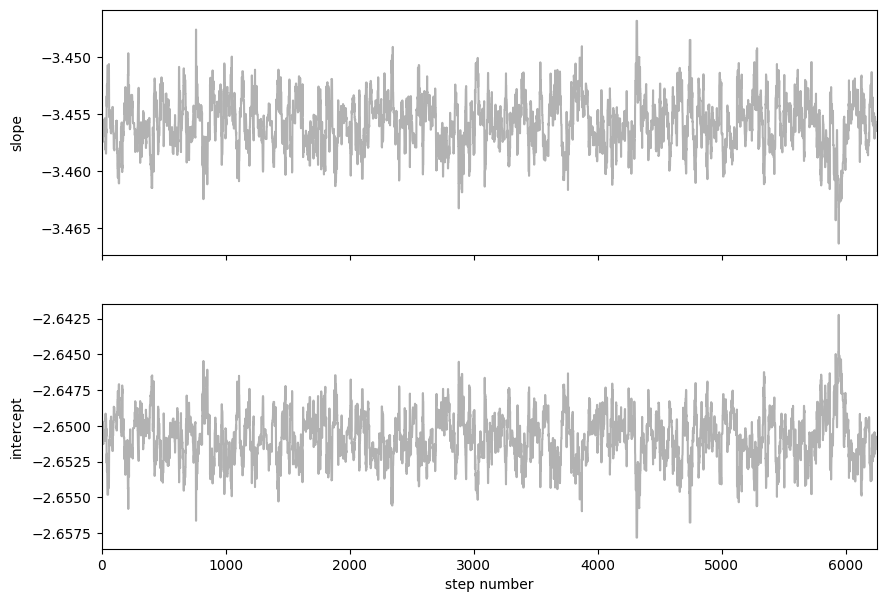

Best-fit parameters: [-3.45579225 -2.6507902 ]


In [ ]:
from Imports import emcee
import matplotlib.pyplot as plt

# Define the log-likelihood function as per our model
def log_likelihood(theta, x, y, yerr):
    m, b = theta
    model = m * x + b
    sigma2 = yerr**2
    return -0.5 * np.sum((y - model)**2 / sigma2 + np.log(sigma2))

# Set the MCMC parameters
ndim = 2  # Number of parameters to fit, m and b for a straight line
nwalkers = 50  # Number of walkers in parallel

# Random initial positions for each walker in a Gaussian ball around the initial guess
p0 = np.random.rand(nwalkers, ndim)

# Instantiate the sampler object from emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=(cepheid_types5['Log10(P)'], cepheid_types5['M_wesenheit_naive_distance'], cepheid_types5['M_Wesenheit_NaiveDistance_Error']))

# Burn-in phase
nBurnSteps = 250
pos, prob, state = sampler.run_mcmc(p0, nBurnSteps)

# Reset the sampler to clear the burn-in phase
sampler.reset()

# Run the production MCMC with 125 iterations
nSteps = 125
sampler.reset()
pos, prob, state = sampler.run_mcmc(pos, nSteps)

# Plotting the chains
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True) # Set up the plot for each parameter
samples = sampler.chain[:, :, :].reshape((-1, ndim)) # Flatten the chain for plotting
labels = ["slope", "intercept"]
for i in range(ndim): # Loop over each parameter
    ax = axes[i]
    ax.plot(samples[:, i], "k", alpha=0.3) # Plot the chain for this parameter
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")
plt.show()

# Number of steps we decide to discard as burn-in
burn_in = 20

# Discard burn-in and flatten the chain
flat_samples = sampler.chain[:, burn_in:, :].reshape((-1, ndim))

# Calculate the best-fit parameters and their uncertainties
mcmc_parameters = np.median(flat_samples, axis=0)
print(f"Best-fit parameters: {mcmc_parameters}")

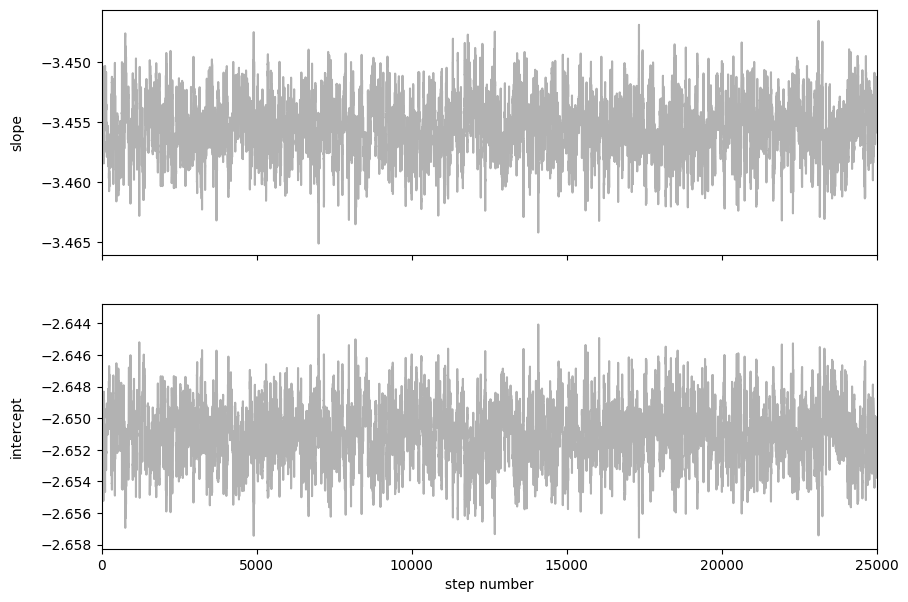

Best-fit parameters: [-3.45545922 -2.6509648 ]


In [ ]:
from Imports import emcee
import matplotlib.pyplot as plt

# Define the log-likelihood function as per our model
def log_likelihood(theta, x, y, yerr):
    m, b = theta
    model = m * x + b
    sigma2 = yerr**2
    return -0.5 * np.sum((y - model)**2 / sigma2 + np.log(sigma2))

# Set the MCMC parameters
ndim = 2  # Number of parameters to fit, m and b for a straight line
nwalkers = 50  # Number of walkers in parallel

# Random initial positions for each walker in a Gaussian ball around the initial guess
p0 = np.random.rand(nwalkers, ndim)

# Instantiate the sampler object from emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=(cepheid_types5['Log10(P)'], cepheid_types5['M_wesenheit_naive_distance'], cepheid_types5['M_Wesenheit_NaiveDistance_Error']))

# Burn-in phase
nBurnSteps = 750
pos, prob, state = sampler.run_mcmc(p0, nBurnSteps)

# Reset the sampler to clear the burn-in phase
sampler.reset()

# Run the production MCMC with 500 iterations
nSteps = 500
sampler.reset()
pos, prob, state = sampler.run_mcmc(pos, nSteps)

# Plotting the chains
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True) # Set up the plot for each parameter
samples = sampler.chain[:, :, :].reshape((-1, ndim)) # Flatten the chain for plotting
labels = ["slope", "intercept"]
for i in range(ndim): # Loop over each parameter
    ax = axes[i]
    ax.plot(samples[:, i], "k", alpha=0.3) # Plot the chain for this parameter
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")
plt.show()

# Number of steps we decide to discard as burn-in
burn_in = 75

# Discard burn-in and flatten the chain
flat_samples = sampler.chain[:, burn_in:, :].reshape((-1, ndim))

# Calculate the best-fit parameters and their uncertainties
mcmc_parameters = np.median(flat_samples, axis=0)
print(f"Best-fit parameters: {mcmc_parameters}")

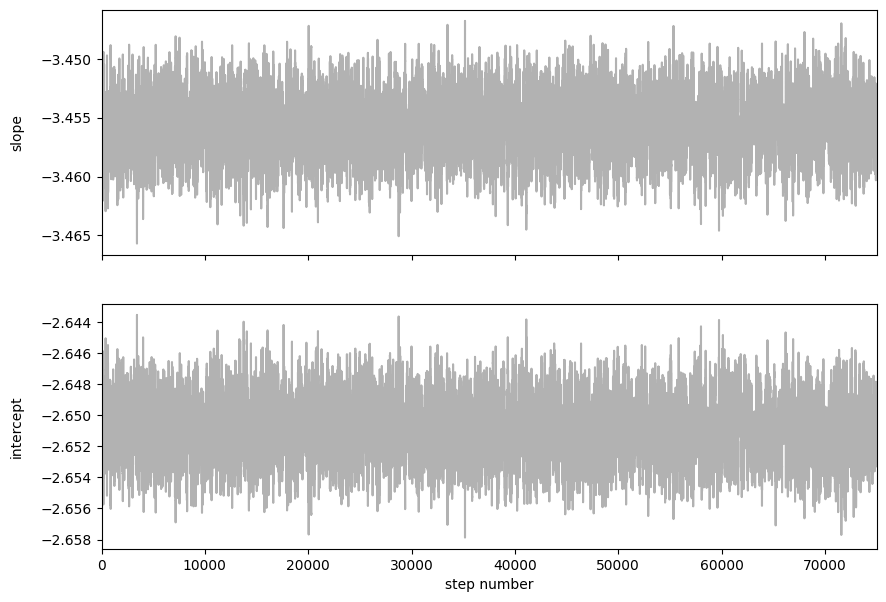

Best-fit parameters: [-3.45563106 -2.65088982]


In [ ]:
from Imports import emcee
import matplotlib.pyplot as plt

# Define the log-likelihood function as per our model
def log_likelihood(theta, x, y, yerr):
    m, b = theta
    model = m * x + b
    sigma2 = yerr**2
    return -0.5 * np.sum((y - model)**2 / sigma2 + np.log(sigma2))

# Set the MCMC parameters
ndim = 2  # Number of parameters to fit, m and b for a straight line
nwalkers = 50  # Number of walkers in parallel

# Random initial positions for each walker in a Gaussian ball around the initial guess
p0 = np.random.rand(nwalkers, ndim)

# Instantiate the sampler object from emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=(cepheid_types5['Log10(P)'], cepheid_types5['M_wesenheit_naive_distance'], cepheid_types5['M_Wesenheit_NaiveDistance_Error']))

# Burn-in phase
nBurnSteps = 1000
pos, prob, state = sampler.run_mcmc(p0, nBurnSteps)

# Reset the sampler to clear the burn-in phase
sampler.reset()

# Run the production MCMC with 1500 iterations
nSteps = 1500
sampler.reset()
pos, prob, state = sampler.run_mcmc(pos, nSteps)

# Plotting the chains
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True) # Set up the plot for each parameter
samples = sampler.chain[:, :, :].reshape((-1, ndim)) # Flatten the chain for plotting
labels = ["slope", "intercept"]
for i in range(ndim): # Loop over each parameter
    ax = axes[i]
    ax.plot(samples[:, i], "k", alpha=0.3) # Plot the chain for this parameter
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")
plt.show()

# Number of steps we decide to discard as burn-in
burn_in = 250

# Discard burn-in and flatten the chain
flat_samples = sampler.chain[:, burn_in:, :].reshape((-1, ndim))

# Calculate the best-fit parameters and their uncertainties
mcmc_parameters = np.median(flat_samples, axis=0)
print(f"Best-fit parameters: {mcmc_parameters}")

# Convergence has occured here because the plots of the parameters "settle down" into a consistent range without trending in one direction or the other
# and the traces of different chains seem to overlap and mix well.

**2) Using the MCMC sampler for the Parameters (slope and intercept) of the fit for Absolute Wesenheit Magnitude calculated using Bailer-Jones Distance Estimates against Log10(P)**

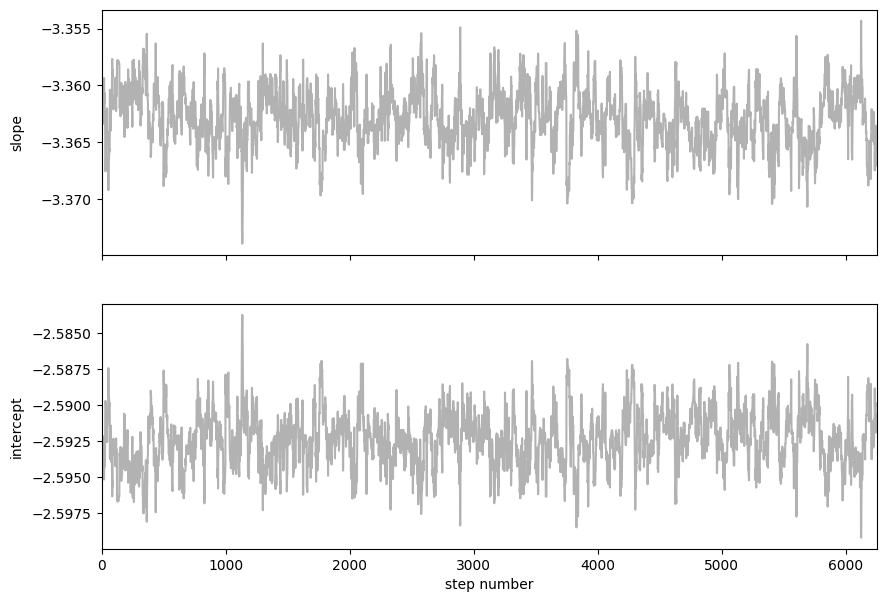

Best-fit parameters: [-3.36279265 -2.59245188]


In [ ]:
from Imports import emcee
import matplotlib.pyplot as plt

# Define the log-likelihood function as per our model
def log_likelihood(theta, x, y, yerr):
    m, b = theta
    model = m * x + b
    sigma2 = yerr**2
    return -0.5 * np.sum((y - model)**2 / sigma2 + np.log(sigma2))

# Set the MCMC parameters
ndim = 2  # Number of parameters to fit, m and b for a straight line
nwalkers = 50  # Number of walkers in parallel

# Random initial positions for each walker in a Gaussian ball around the initial guess
p0 = np.random.rand(nwalkers, ndim)

# Instantiate the sampler object from emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=(cepheid_types5['Log10(P)'], cepheid_types5['M_wesenheit_Bailer'], cepheid_types5['M_wesenheit_BailerError']))

# Burn-in phase
nBurnSteps = 250
pos, prob, state = sampler.run_mcmc(p0, nBurnSteps)

# Reset the sampler to clear the burn-in phase
sampler.reset()

# Run the production MCMC with 125 iterations
nSteps = 125
sampler.reset()
pos, prob, state = sampler.run_mcmc(pos, nSteps)

# Plotting the chains
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True) # Set up the plot for each parameter
samples = sampler.chain[:, :, :].reshape((-1, ndim)) # Flatten the chain for plotting
labels = ["slope", "intercept"]
for i in range(ndim): # Loop over each parameter
    ax = axes[i]
    ax.plot(samples[:, i], "k", alpha=0.3) # Plot the chain for this parameter
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")
plt.show()

# Number of steps we decide to discard as burn-in
burn_in = 20

# Discard burn-in and flatten the chain
flat_samples = sampler.chain[:, burn_in:, :].reshape((-1, ndim))

# Calculate the best-fit parameters and their uncertainties
mcmc_parameters = np.median(flat_samples, axis=0)
print(f"Best-fit parameters: {mcmc_parameters}")

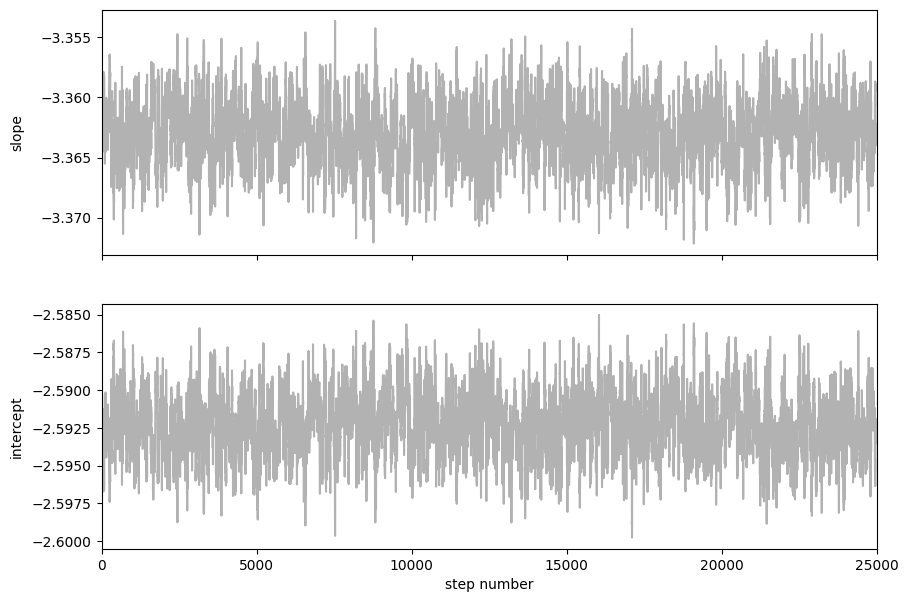

Best-fit parameters: [-3.3629605  -2.59233744]


In [ ]:
from Imports import emcee
import matplotlib.pyplot as plt

# Define the log-likelihood function as per our model
def log_likelihood(theta, x, y, yerr):
    m, b = theta
    model = m * x + b
    sigma2 = yerr**2
    return -0.5 * np.sum((y - model)**2 / sigma2 + np.log(sigma2))

# Set the MCMC parameters
ndim = 2  # Number of parameters to fit, m and b for a straight line
nwalkers = 50  # Number of walkers in parallel

# Random initial positions for each walker in a Gaussian ball around the initial guess
p0 = np.random.rand(nwalkers, ndim)

# Instantiate the sampler object from emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=(cepheid_types5['Log10(P)'], cepheid_types5['M_wesenheit_Bailer'], cepheid_types5['M_wesenheit_BailerError']))

# Burn-in phase
nBurnSteps = 750
pos, prob, state = sampler.run_mcmc(p0, nBurnSteps)

# Reset the sampler to clear the burn-in phase
sampler.reset()

# Run the production MCMC with 500 iterations
nSteps = 500
sampler.reset()
pos, prob, state = sampler.run_mcmc(pos, nSteps)

# Plotting the chains
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True) # Set up the plot for each parameter
samples = sampler.chain[:, :, :].reshape((-1, ndim)) # Flatten the chain for plotting
labels = ["slope", "intercept"]
for i in range(ndim): # Loop over each parameter
    ax = axes[i]
    ax.plot(samples[:, i], "k", alpha=0.3) # Plot the chain for this parameter
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")
plt.show()

# Number of steps we decide to discard as burn-in
burn_in = 75

# Discard burn-in and flatten the chain
flat_samples = sampler.chain[:, burn_in:, :].reshape((-1, ndim))

# Calculate the best-fit parameters and their uncertainties
mcmc_parameters = np.median(flat_samples, axis=0)
print(f"Best-fit parameters: {mcmc_parameters}")

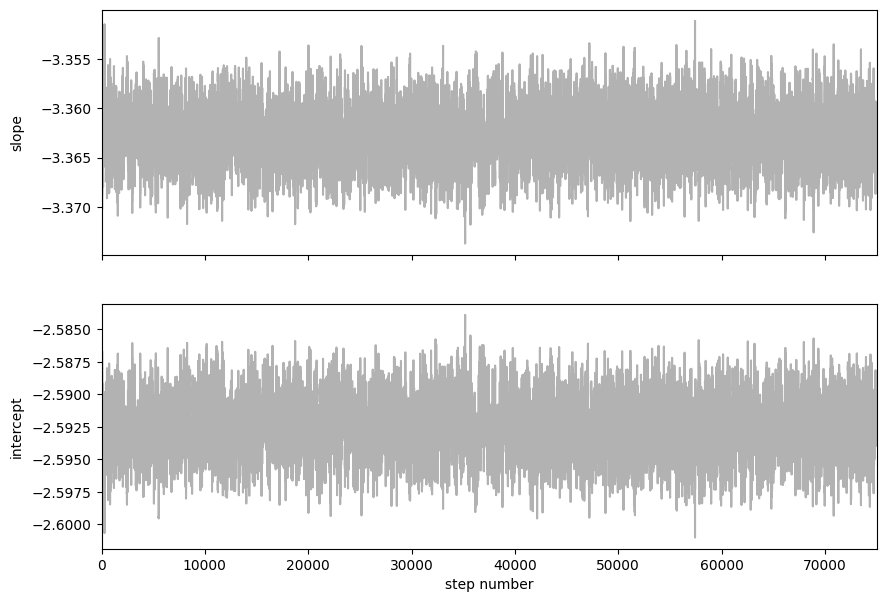

Best-fit parameters: [-3.36268292 -2.59254472]


In [ ]:
from Imports import emcee
import matplotlib.pyplot as plt

# Define the log-likelihood function as per our model
def log_likelihood(theta, x, y, yerr):
    m, b = theta
    model = m * x + b
    sigma2 = yerr**2
    return -0.5 * np.sum((y - model)**2 / sigma2 + np.log(sigma2))

# Set the MCMC parameters
ndim = 2  # Number of parameters to fit, m and b for a straight line
nwalkers = 50  # Number of walkers in parallel

# Random initial positions for each walker in a Gaussian ball around the initial guess
p0 = np.random.rand(nwalkers, ndim)

# Instantiate the sampler object from emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=(cepheid_types5['Log10(P)'], cepheid_types5['M_wesenheit_Bailer'], cepheid_types5['M_wesenheit_BailerError']))

# Burn-in phase
nBurnSteps = 1000
pos, prob, state = sampler.run_mcmc(p0, nBurnSteps)

# Reset the sampler to clear the burn-in phase
sampler.reset()

# Run the production MCMC with 1500 iterations
nSteps = 1500
sampler.reset()
pos, prob, state = sampler.run_mcmc(pos, nSteps)

# Plotting the chains
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True) # Set up the plot for each parameter
samples = sampler.chain[:, :, :].reshape((-1, ndim)) # Flatten the chain for plotting
labels = ["slope", "intercept"]
for i in range(ndim): # Loop over each parameter
    ax = axes[i]
    ax.plot(samples[:, i], "k", alpha=0.3) # Plot the chain for this parameter
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")
plt.show()

# Number of steps we decide to discard as burn-in
burn_in = 250

# Discard burn-in and flatten the chain
flat_samples = sampler.chain[:, burn_in:, :].reshape((-1, ndim))

# Calculate the best-fit parameters and their uncertainties
mcmc_parameters = np.median(flat_samples, axis=0)
print(f"Best-fit parameters: {mcmc_parameters}")

# Convergence has occured here because the plots of the parameters "settle down" into a consistent range without trending in one direction or the other
# and the traces of different chains seem to overlap and mix well.

# Part 3: Use your calibrated PWR to determine the distance to the Large Magellanic Cloud (LMC)

Select all delta cepheids in the LMC using a box in galactic coordinates defined by the longitude and latitude range $l=(273, 285)$, $b=(-38, -28)$. Use the best-fitting results from your final calibrated PWR (use the Bailer-Jones PWR), as well as the periods and apparent $W_{G}$ magnitudes to determine the distance to the LMC.

To do this, you can do the following:
* Use you calibrated PWR to determine the predicted $M_W$ for all Cepheid periods in the LMC, then measure the difference between the predicted value and the apparent $W_{G}$ magnitude. This effectively gives the distance modulus for each Cepheid, from which a sample of distance moduli and, hence, distances can be determined.
* <font color='blue'> **(3a)** Plot up a histogram of the distances determined for the Cephieds in your sample. </font>
* <font color='blue'> **(3b)** From the distribution of distances, determine the median and 68th percentile ranges of the distance to the LMC. How do these values compare with current estimates of the distance to the LMC?</font>
* <font color='blue'> **(3c)** Given your measured distance and the uncertainties on the parallax measurements for Cephieds in the LMC, would it be possible to use Gaia DR3 parallaxes to determine the distance to the LMC?</font>



In [ ]:
# cepheid_types4 is our DataFrame with all the required information
# Filter for Cepheids in the LMC
LMC_cepheids = cepheid_types4[(cepheid_types4['L'] > 273) & (cepheid_types4['L'] < 285) & (cepheid_types4['B'] > -38) & (cepheid_types4['B'] < -28)]

# Now, LMC_cepheids is the new DataFrame that contains the cepheid stars in the LMC in order for us to do further calculations.

# 'Log10(P)' is the log10 of the period and 'Wesenheit' is the apparent Wesenheit magnitude.
# best_parameters2 contains our slope and intercept from the linear fit (Bailer-Jones PWR)
slope, intercept = best_parameters2

# Calculate the predicted absolute magnitude M_W using the PWR
Predicted_MW = slope * LMC_cepheids['Log10(P)'] + intercept

# Calculate the distance modulus for each Cepheid
distance_modulus = LMC_cepheids['Wesenheit'] - Predicted_MW

# Convert distance modulus to distance in parsecs
# The formula is distance = 10^(1 + (distance_modulus / 5))
LMC_distance_pc = 10**(1 + (distance_modulus / 5))

# Add the calculated distances to your DataFrame
LMC_cepheids['LMC_distance_pc'] = LMC_distance_pc

# Output the first few rows to check
print(LMC_cepheids)

# Calculate the mean distance to the LMC
mean_distance = np.mean(LMC_cepheids['LMC_distance_pc'])
print(f"The mean distance to the LMC is: {mean_distance} parsecs")

                 source_id    r_med_geo     r_lo_geo     r_hi_geo   flag  \
486    4663665946029028608  1341.838745  1143.748779  1591.265991  10033   
4308   4658248721135834624  5347.490234  4786.614746  6046.867676  10023   
5228   4656427349891031936  2515.040039  2417.929443  2638.260498  10033   
5882   4660215133131474304  1413.295410  1294.506836  1569.786621  10033   
9366   4651832387749602688  1041.440430   889.100586  1207.863281  10033   
10663  4651091110761609472  1879.196655  1644.580933  2236.909668  10112   

              ra        dec           L          B  parallax  ...  \
486    79.098059 -64.913599  274.877556 -34.403146  0.725283  ...   
4308   78.526277 -69.073906  279.864660 -33.840604  0.146566  ...   
5228   69.635609 -67.646314  279.327993 -37.385665  0.363540  ...   
5882   82.676067 -66.878240  276.962701 -32.679399  0.658357  ...   
9366   82.864362 -71.168205  281.975660 -31.992461  0.950729  ...   
10663  83.422657 -70.986816  281.730517 -31.842853  0

<ipython-input-63-a9ffc56ee1c3>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LMC_cepheids['LMC_distance_pc'] = LMC_distance_pc


In [ ]:
print(LMC_cepheids['parallax_error'])

486      0.144924
4308     0.025612
5228     0.016575
5882     0.081690
9366     0.148857
10663    0.083698
Name: parallax_error, dtype: float32


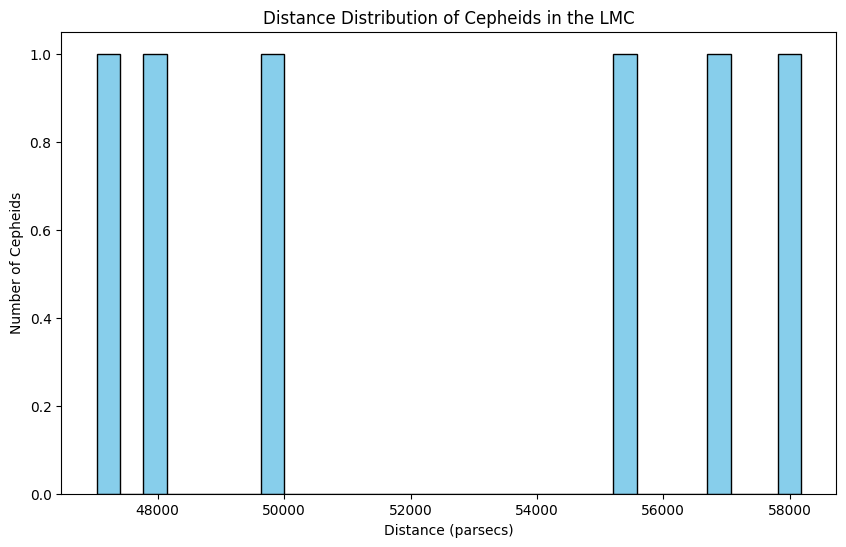

The median of the distance to the LMC is : 52744.48959632775
The 68th percentile ranges of the distance to the LMC is [47743.72835618 57090.45165224]


In [ ]:
# Task 3(a): Plot up a histogram of the distances

plt.figure(figsize=(10, 6))
plt.hist(LMC_cepheids['LMC_distance_pc'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Distance (parsecs)')
plt.ylabel('Number of Cepheids')
plt.title('Distance Distribution of Cepheids in the LMC')
plt.show()

# Task 3(b): Determine the median and 68th percentile ranges of the distance
median_distance = np.median(LMC_cepheids['LMC_distance_pc'])
percentile_68 = np.percentile(LMC_cepheids['LMC_distance_pc'], [16, 84])
print("The median of the distance to the LMC is :" , median_distance)
print("The 68th percentile ranges of the distance to the LMC is" , percentile_68)